<a href="https://colab.research.google.com/github/blufzzz/Dynamic-Texture-3D-CNN/blob/master/3D_CNN_Video_AR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### This notebook is demo for dynamic texture synthesis via auto-regresion of the frame sequence

In [0]:
# import urllib
# import requests
# from os import path
# # нужна информация о нашей системе
# from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
# platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

# # уточним на чем будем вычислять
# accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

# !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

tcmalloc: large alloc 1073750016 bytes == 0x570e6000 @  0x7ff0155a72a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
fastai 1.0.41 has requirement torch>=1.0.0, but you'll have torch 0.4.1 which is incompatible.


In [0]:
# !pip install --no-cache-dir -I pillow

    100% |████████████████████████████████| 2.0MB 65.5MB/s 
fastai 1.0.41 has requirement torch>=1.0.0, but you'll have torch 0.4.1 which is incompatible.
  [PIL]
You must restart the runtime in order to use newly installed versions.


In [0]:
from skimage import io
import cv2
import os
import sys
import re
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.core.display import clear_output
import torch
import torchvision
from torch import nn
from torch.utils.data import Dataset, DataLoader

In [0]:
# from google.colab import drive

# drive.mount('/content/gdrive')

In [3]:
cd ./gdrive/My\ Drive/Colab Notebooks/two-stream-dyntex-synth

/content/gdrive/My Drive/Colab Notebooks/two-stream-dyntex-synth


# Define model

In [0]:
class CNN3D(nn.Module):
  
  def __init__(self):
    
    super(CNN3D, self).__init__()
    
    self.d_conv1 = nn.Conv3d(3,64, (3,3,3), stride=1, padding=(0,1,1), bias=True)
    self.d_pool1 = nn.MaxPool3d((1,2,2), stride = (1,2,2))
    
    self.d_conv2 = nn.Conv3d(64, 128, (2,3,3), stride=1, padding=(0,1,1), bias=True)
    self.d_pool2 = nn.MaxPool3d((1,2,2), stride = (1,2,2))

    self.d_conv3 = nn.Conv3d(128, 256, (2,3,3), stride=1, padding=(0,1,1), bias=True)
    self.d_pool3 = nn.MaxPool3d((1,2,2), stride = (1,2,2))
    
    self.d_conv4 = nn.Conv3d(256, 512, (2,3,3), stride=1, padding=(0,1,1), bias=True)
    self.d_pool4 = nn.MaxPool3d((1,2,2), stride = (1,2,2))
        
    
    self.u_unconv1 = nn.ConvTranspose2d(512, 256, (2,2), stride = 2, bias=True)
    self.u_conv1 = nn.Conv2d(256, 256, (3,3), stride = 1, padding=(1,1), bias=True)
    
    self.u_unconv2 = nn.ConvTranspose2d(256, 128, (2,2), stride = 2, bias=True)
    self.u_conv2= nn.Conv2d(128, 128, (3,3), stride = 1, padding=(1,1), bias=True)
    
    self.u_unconv3 = nn.ConvTranspose2d(128, 64, (2,2), stride = 2, bias=True)
    self.u_conv3 = nn.Conv2d(64, 64, (3,3), stride = 1, padding=(1,1), bias=True)

    self.u_unconv4 = nn.ConvTranspose2d(64,3, (1,1), stride = 1, bias=True)
    self.u_conv4 = nn.Conv2d(3, 3, (1,1), stride = 1, bias=True)

    self.relu = nn.LeakyReLU()
        
  def forward(self, x):

    x = self.d_conv1(x)
    self.res1 = x
#     print ('d_conv1',x.shape)
    x = self.d_pool1(x)
    x = self.relu(x)
#     print ('d_pool1',x.shape)
    
    x = self.d_conv2(x)
    self.res2 = x
#     print ('d_conv2',x.shape)
    x = self.d_pool2(x)
    x = self.relu(x)
#     print ('d_pool2',x.shape)
    
    x = self.d_conv3(x)
    self.res3 = x
#     print ('d_conv3',x.shape)
    x = self.d_pool3(x)
    x = self.relu(x)
#     print ('d_pool3',x.shape)
    
    x = self.d_conv4(x)
    self.res4 = x
#     print ('d_conv4',x.shape)
    x = self.relu(x)
    
    x = x.reshape(1,x.shape[1], x.shape[-1], x.shape[-1])
    
    x = self.u_unconv1(x)
#     print ('u_unconv1',x.shape)

#     x = torch.cat([self.res1, x])
    x = self.u_conv1(x)
#     print ('u_conv1',x.shape)
    x = self.relu(x)
    
    x = self.u_unconv2(x)
#     print ('u_unconv2',x.shape)
#     x = torch.cat([self.res2, x])
    x = self.u_conv2(x)
#     print ('u_conv2',x.shape)
    x = self.relu(x)
    
    x = self.u_unconv3(x)
#     print ('u_unconv3',x.shape)
#     x = torch.cat([self.res3, x])
    x = self.u_conv3(x)
#     print ('u_conv3',x.shape)
    x = self.relu(x)
    
    x = self.u_unconv4(x)
#     print ('u_unconv4',x.shape)
#     x = torch.cat([self.res4, x])
    x = self.u_conv4(x)
#     print ('u_conv4',x.shape)
    x = self.relu(x)    
    
    return x
  

In [0]:
# img = plt.imread('./data/dynamic_textures/flag/frame_00000000.png').transpose(2,0,1)

# imgs = np.array([[img]*6])

# imgs = imgs.transpose(0,2,1,3,4)

# imgs = torch.Tensor(imgs)

# imgs.shape

In [0]:
def get_seq(fold, seq_len):
  
  names = sorted(os.listdir(fold))
  
  n_framesets = len(names) - seq_len + 1
  
  for i in range(n_framesets - 1):
  
    imgs = []
    
    y = io.imread(os.path.join(fold, names[i+seq_len])).transpose(2,0,1)
   
    y = np.expand_dims(y,0)
    
    for name in names[i:i+seq_len]:
  
      imgs += [io.imread(os.path.join(fold, name)).transpose(2,0,1)]
  
    imgs = np.array([imgs]).transpose(0,2,1,3,4)
  
    yield torch.Tensor(imgs), torch.Tensor(y)
    
def deprocess(img_tensor):
  
  return img_tensor[0].detach().cpu().numpy().astype('uint8').transpose(1,2,0)    

# Train model

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch 0


  0%|          | 1/1000 [00:05<1:27:09,  5.23s/it]

epoch 1


  0%|          | 2/1000 [00:06<1:09:43,  4.19s/it]

epoch 2


  0%|          | 3/1000 [00:08<57:24,  3.45s/it]  

epoch 3


  0%|          | 4/1000 [00:10<48:54,  2.95s/it]

epoch 4


  0%|          | 5/1000 [00:12<42:55,  2.59s/it]

epoch 5


  1%|          | 6/1000 [00:13<38:44,  2.34s/it]

epoch 6


  1%|          | 7/1000 [00:15<35:48,  2.16s/it]

epoch 7


  1%|          | 8/1000 [00:17<33:43,  2.04s/it]

epoch 8


  1%|          | 9/1000 [00:19<32:19,  1.96s/it]

epoch 9


  1%|          | 10/1000 [00:21<31:15,  1.89s/it]

epoch 10


  1%|          | 11/1000 [00:22<30:35,  1.86s/it]

epoch 11


  1%|          | 12/1000 [00:24<30:01,  1.82s/it]

epoch 12


  1%|▏         | 13/1000 [00:26<29:41,  1.80s/it]

epoch 13


  1%|▏         | 14/1000 [00:28<29:21,  1.79s/it]

epoch 14


  2%|▏         | 15/1000 [00:29<29:13,  1.78s/it]

epoch 15


  2%|▏         | 16/1000 [00:31<28:59,  1.77s/it]

epoch 16


  2%|▏         | 17/1000 [00:33<28:59,  1.77s/it]

epoch 17


  2%|▏         | 18/1000 [00:35<28:48,  1.76s/it]

epoch 18


  2%|▏         | 19/1000 [00:36<28:49,  1.76s/it]

epoch 19


  2%|▏         | 20/1000 [00:38<28:41,  1.76s/it]

epoch 20


  2%|▏         | 21/1000 [00:40<28:43,  1.76s/it]

epoch 21


  2%|▏         | 22/1000 [00:42<28:36,  1.76s/it]

epoch 22


  2%|▏         | 23/1000 [00:43<28:41,  1.76s/it]

epoch 23


  2%|▏         | 24/1000 [00:45<28:33,  1.76s/it]

epoch 24


  2%|▎         | 25/1000 [00:47<28:37,  1.76s/it]

epoch 25


  3%|▎         | 26/1000 [00:49<28:30,  1.76s/it]

epoch 26


  3%|▎         | 27/1000 [00:50<28:34,  1.76s/it]

epoch 27


  3%|▎         | 28/1000 [00:52<28:27,  1.76s/it]

epoch 28


  3%|▎         | 29/1000 [00:54<28:30,  1.76s/it]

epoch 29


  3%|▎         | 30/1000 [00:56<28:23,  1.76s/it]

epoch 30


  3%|▎         | 31/1000 [00:57<28:27,  1.76s/it]

epoch 31


  3%|▎         | 32/1000 [00:59<28:19,  1.76s/it]

epoch 32


  3%|▎         | 33/1000 [01:01<28:23,  1.76s/it]

epoch 33


  3%|▎         | 34/1000 [01:03<28:15,  1.76s/it]

epoch 34


  4%|▎         | 35/1000 [01:04<28:19,  1.76s/it]

epoch 35


  4%|▎         | 36/1000 [01:06<28:14,  1.76s/it]

epoch 36


  4%|▎         | 37/1000 [01:08<28:15,  1.76s/it]

epoch 37


  4%|▍         | 38/1000 [01:10<28:10,  1.76s/it]

epoch 38


  4%|▍         | 39/1000 [01:11<28:13,  1.76s/it]

epoch 39


  4%|▍         | 40/1000 [01:13<28:07,  1.76s/it]

epoch 40


  4%|▍         | 41/1000 [01:15<28:07,  1.76s/it]

epoch 41


  4%|▍         | 42/1000 [01:17<28:01,  1.76s/it]

epoch 42


  4%|▍         | 43/1000 [01:19<28:03,  1.76s/it]

epoch 43


  4%|▍         | 44/1000 [01:20<27:58,  1.76s/it]

epoch 44


  4%|▍         | 45/1000 [01:22<27:58,  1.76s/it]

epoch 45


  5%|▍         | 46/1000 [01:24<27:54,  1.76s/it]

epoch 46


  5%|▍         | 47/1000 [01:26<27:57,  1.76s/it]

epoch 47


  5%|▍         | 48/1000 [01:27<27:54,  1.76s/it]

epoch 48


  5%|▍         | 49/1000 [01:29<27:51,  1.76s/it]

epoch 49


  5%|▌         | 50/1000 [01:31<27:48,  1.76s/it]

epoch 50


  5%|▌         | 51/1000 [01:33<27:47,  1.76s/it]

epoch 51


  5%|▌         | 52/1000 [01:34<27:44,  1.76s/it]

epoch 52


  5%|▌         | 53/1000 [01:36<27:45,  1.76s/it]

epoch 53


  5%|▌         | 54/1000 [01:38<27:41,  1.76s/it]

epoch 54


  6%|▌         | 55/1000 [01:40<27:42,  1.76s/it]

epoch 55


  6%|▌         | 56/1000 [01:41<27:41,  1.76s/it]

epoch 56


  6%|▌         | 57/1000 [01:43<27:39,  1.76s/it]

epoch 57


  6%|▌         | 58/1000 [01:45<27:40,  1.76s/it]

epoch 58


  6%|▌         | 59/1000 [01:47<27:33,  1.76s/it]

epoch 59


  6%|▌         | 60/1000 [01:48<27:34,  1.76s/it]

epoch 60


  6%|▌         | 61/1000 [01:50<27:30,  1.76s/it]

epoch 61


  6%|▌         | 62/1000 [01:52<27:30,  1.76s/it]

epoch 62


  6%|▋         | 63/1000 [01:54<27:25,  1.76s/it]

epoch 63


  6%|▋         | 64/1000 [01:55<27:29,  1.76s/it]

epoch 64


  6%|▋         | 65/1000 [01:57<27:22,  1.76s/it]

epoch 65


  7%|▋         | 66/1000 [01:59<27:25,  1.76s/it]

epoch 66


  7%|▋         | 67/1000 [02:01<27:18,  1.76s/it]

epoch 67


  7%|▋         | 68/1000 [02:02<27:23,  1.76s/it]

epoch 68


  7%|▋         | 69/1000 [02:04<27:15,  1.76s/it]

epoch 69


  7%|▋         | 70/1000 [02:06<27:19,  1.76s/it]

epoch 70


  7%|▋         | 71/1000 [02:08<27:12,  1.76s/it]

epoch 71


  7%|▋         | 72/1000 [02:10<27:13,  1.76s/it]

epoch 72


  7%|▋         | 73/1000 [02:11<27:08,  1.76s/it]

epoch 73


  7%|▋         | 74/1000 [02:13<27:10,  1.76s/it]

epoch 74


  8%|▊         | 75/1000 [02:15<27:04,  1.76s/it]

epoch 75


  8%|▊         | 76/1000 [02:17<27:08,  1.76s/it]

epoch 76


  8%|▊         | 77/1000 [02:18<27:02,  1.76s/it]

epoch 77


  8%|▊         | 78/1000 [02:20<27:04,  1.76s/it]

epoch 78


  8%|▊         | 79/1000 [02:22<26:58,  1.76s/it]

epoch 79


  8%|▊         | 80/1000 [02:24<27:00,  1.76s/it]

epoch 80


  8%|▊         | 81/1000 [02:25<26:57,  1.76s/it]

epoch 81


  8%|▊         | 82/1000 [02:27<26:55,  1.76s/it]

epoch 82


  8%|▊         | 83/1000 [02:29<26:53,  1.76s/it]

epoch 83


  8%|▊         | 84/1000 [02:31<26:51,  1.76s/it]

epoch 84


  8%|▊         | 85/1000 [02:32<26:52,  1.76s/it]

epoch 85


  9%|▊         | 86/1000 [02:34<26:47,  1.76s/it]

epoch 86


  9%|▊         | 87/1000 [02:36<26:49,  1.76s/it]

epoch 87


  9%|▉         | 88/1000 [02:38<26:42,  1.76s/it]

epoch 88


  9%|▉         | 89/1000 [02:39<26:45,  1.76s/it]

epoch 89


  9%|▉         | 90/1000 [02:41<26:38,  1.76s/it]

epoch 90


  9%|▉         | 91/1000 [02:43<26:42,  1.76s/it]

epoch 91


  9%|▉         | 92/1000 [02:45<26:34,  1.76s/it]

epoch 92


  9%|▉         | 93/1000 [02:46<26:39,  1.76s/it]

epoch 93


  9%|▉         | 94/1000 [02:48<26:33,  1.76s/it]

epoch 94


 10%|▉         | 95/1000 [02:50<26:35,  1.76s/it]

epoch 95


 10%|▉         | 96/1000 [02:52<26:30,  1.76s/it]

epoch 96


 10%|▉         | 97/1000 [02:54<26:32,  1.76s/it]

epoch 97


 10%|▉         | 98/1000 [02:55<26:30,  1.76s/it]

epoch 98


 10%|▉         | 99/1000 [02:57<26:25,  1.76s/it]

epoch 99


 10%|█         | 100/1000 [02:59<26:22,  1.76s/it]

epoch 100


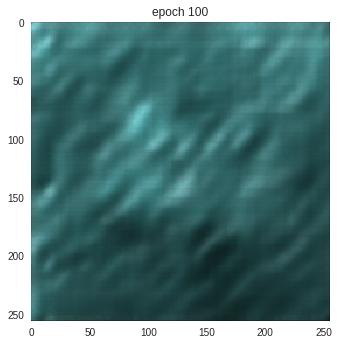

 10%|█         | 101/1000 [03:01<28:49,  1.92s/it]

epoch 101


 10%|█         | 102/1000 [03:03<27:13,  1.82s/it]

epoch 102


 10%|█         | 103/1000 [03:04<26:58,  1.80s/it]

epoch 103


 10%|█         | 104/1000 [03:06<26:40,  1.79s/it]

epoch 104


 10%|█         | 105/1000 [03:08<26:35,  1.78s/it]

epoch 105


 11%|█         | 106/1000 [03:10<26:24,  1.77s/it]

epoch 106


 11%|█         | 107/1000 [03:11<26:23,  1.77s/it]

epoch 107


 11%|█         | 108/1000 [03:13<26:15,  1.77s/it]

epoch 108


 11%|█         | 109/1000 [03:15<26:13,  1.77s/it]

epoch 109


 11%|█         | 110/1000 [03:17<26:07,  1.76s/it]

epoch 110


 11%|█         | 111/1000 [03:19<26:05,  1.76s/it]

epoch 111


 11%|█         | 112/1000 [03:20<26:02,  1.76s/it]

epoch 112


 11%|█▏        | 113/1000 [03:22<26:01,  1.76s/it]

epoch 113


 11%|█▏        | 114/1000 [03:24<25:58,  1.76s/it]

epoch 114


 12%|█▏        | 115/1000 [03:26<25:59,  1.76s/it]

epoch 115


 12%|█▏        | 116/1000 [03:27<26:01,  1.77s/it]

epoch 116


 12%|█▏        | 117/1000 [03:29<25:54,  1.76s/it]

epoch 117


 12%|█▏        | 118/1000 [03:31<25:54,  1.76s/it]

epoch 118


 12%|█▏        | 119/1000 [03:33<25:47,  1.76s/it]

epoch 119


 12%|█▏        | 120/1000 [03:34<25:50,  1.76s/it]

epoch 120


 12%|█▏        | 121/1000 [03:36<25:44,  1.76s/it]

epoch 121


 12%|█▏        | 122/1000 [03:38<25:46,  1.76s/it]

epoch 122


 12%|█▏        | 123/1000 [03:40<25:41,  1.76s/it]

epoch 123


 12%|█▏        | 124/1000 [03:41<25:44,  1.76s/it]

epoch 124


 12%|█▎        | 125/1000 [03:43<25:38,  1.76s/it]

epoch 125


 13%|█▎        | 126/1000 [03:45<25:41,  1.76s/it]

epoch 126


 13%|█▎        | 127/1000 [03:47<25:39,  1.76s/it]

epoch 127


 13%|█▎        | 128/1000 [03:48<25:37,  1.76s/it]

epoch 128


 13%|█▎        | 129/1000 [03:50<25:36,  1.76s/it]

epoch 129


 13%|█▎        | 130/1000 [03:52<25:32,  1.76s/it]

epoch 130


 13%|█▎        | 131/1000 [03:54<25:30,  1.76s/it]

epoch 131


 13%|█▎        | 132/1000 [03:55<25:26,  1.76s/it]

epoch 132


 13%|█▎        | 133/1000 [03:57<25:29,  1.76s/it]

epoch 133


 13%|█▎        | 134/1000 [03:59<25:23,  1.76s/it]

epoch 134


 14%|█▎        | 135/1000 [04:01<25:27,  1.77s/it]

epoch 135


 14%|█▎        | 136/1000 [04:03<25:21,  1.76s/it]

epoch 136


 14%|█▎        | 137/1000 [04:04<25:21,  1.76s/it]

epoch 137


 14%|█▍        | 138/1000 [04:06<25:14,  1.76s/it]

epoch 138


 14%|█▍        | 139/1000 [04:08<25:15,  1.76s/it]

epoch 139


 14%|█▍        | 140/1000 [04:10<25:10,  1.76s/it]

epoch 140


 14%|█▍        | 141/1000 [04:11<25:11,  1.76s/it]

epoch 141


 14%|█▍        | 142/1000 [04:13<25:06,  1.76s/it]

epoch 142


 14%|█▍        | 143/1000 [04:15<25:09,  1.76s/it]

epoch 143


 14%|█▍        | 144/1000 [04:17<25:05,  1.76s/it]

epoch 144


 14%|█▍        | 145/1000 [04:18<25:05,  1.76s/it]

epoch 145


 15%|█▍        | 146/1000 [04:20<25:05,  1.76s/it]

epoch 146


 15%|█▍        | 147/1000 [04:22<25:00,  1.76s/it]

epoch 147


 15%|█▍        | 148/1000 [04:24<25:00,  1.76s/it]

epoch 148


 15%|█▍        | 149/1000 [04:25<24:56,  1.76s/it]

epoch 149


 15%|█▌        | 150/1000 [04:27<24:59,  1.76s/it]

epoch 150


 15%|█▌        | 151/1000 [04:29<24:52,  1.76s/it]

epoch 151


 15%|█▌        | 152/1000 [04:31<24:54,  1.76s/it]

epoch 152


 15%|█▌        | 153/1000 [04:32<24:48,  1.76s/it]

epoch 153


 15%|█▌        | 154/1000 [04:34<24:51,  1.76s/it]

epoch 154


 16%|█▌        | 155/1000 [04:36<24:45,  1.76s/it]

epoch 155


 16%|█▌        | 156/1000 [04:38<24:48,  1.76s/it]

epoch 156


 16%|█▌        | 157/1000 [04:39<24:42,  1.76s/it]

epoch 157


 16%|█▌        | 158/1000 [04:41<24:44,  1.76s/it]

epoch 158


 16%|█▌        | 159/1000 [04:43<24:38,  1.76s/it]

epoch 159


 16%|█▌        | 160/1000 [04:45<24:40,  1.76s/it]

epoch 160


 16%|█▌        | 161/1000 [04:47<24:38,  1.76s/it]

epoch 161


 16%|█▌        | 162/1000 [04:48<24:36,  1.76s/it]

epoch 162


 16%|█▋        | 163/1000 [04:50<24:36,  1.76s/it]

epoch 163


 16%|█▋        | 164/1000 [04:52<24:31,  1.76s/it]

epoch 164


 16%|█▋        | 165/1000 [04:54<24:33,  1.77s/it]

epoch 165


 17%|█▋        | 166/1000 [04:55<24:25,  1.76s/it]

epoch 166


 17%|█▋        | 167/1000 [04:57<24:28,  1.76s/it]

epoch 167


 17%|█▋        | 168/1000 [04:59<24:22,  1.76s/it]

epoch 168


 17%|█▋        | 169/1000 [05:01<24:23,  1.76s/it]

epoch 169


 17%|█▋        | 170/1000 [05:02<24:15,  1.75s/it]

epoch 170


 17%|█▋        | 171/1000 [05:04<24:19,  1.76s/it]

epoch 171


 17%|█▋        | 172/1000 [05:06<24:13,  1.76s/it]

epoch 172


 17%|█▋        | 173/1000 [05:08<24:15,  1.76s/it]

epoch 173


 17%|█▋        | 174/1000 [05:09<24:09,  1.75s/it]

epoch 174


 18%|█▊        | 175/1000 [05:11<24:13,  1.76s/it]

epoch 175


 18%|█▊        | 176/1000 [05:13<24:08,  1.76s/it]

epoch 176


 18%|█▊        | 177/1000 [05:15<24:10,  1.76s/it]

epoch 177


 18%|█▊        | 178/1000 [05:16<24:05,  1.76s/it]

epoch 178


 18%|█▊        | 179/1000 [05:18<24:06,  1.76s/it]

epoch 179


 18%|█▊        | 180/1000 [05:20<24:03,  1.76s/it]

epoch 180


 18%|█▊        | 181/1000 [05:22<24:01,  1.76s/it]

epoch 181


 18%|█▊        | 182/1000 [05:24<24:01,  1.76s/it]

epoch 182


 18%|█▊        | 183/1000 [05:25<23:57,  1.76s/it]

epoch 183


 18%|█▊        | 184/1000 [05:27<23:58,  1.76s/it]

epoch 184


 18%|█▊        | 185/1000 [05:29<23:52,  1.76s/it]

epoch 185


 19%|█▊        | 186/1000 [05:31<23:55,  1.76s/it]

epoch 186


 19%|█▊        | 187/1000 [05:32<23:48,  1.76s/it]

epoch 187


 19%|█▉        | 188/1000 [05:34<23:49,  1.76s/it]

epoch 188


 19%|█▉        | 189/1000 [05:36<23:45,  1.76s/it]

epoch 189


 19%|█▉        | 190/1000 [05:38<23:47,  1.76s/it]

epoch 190


 19%|█▉        | 191/1000 [05:39<23:42,  1.76s/it]

epoch 191


 19%|█▉        | 192/1000 [05:41<23:44,  1.76s/it]

epoch 192


 19%|█▉        | 193/1000 [05:43<23:38,  1.76s/it]

epoch 193


 19%|█▉        | 194/1000 [05:45<23:41,  1.76s/it]

epoch 194


 20%|█▉        | 195/1000 [05:46<23:39,  1.76s/it]

epoch 195


 20%|█▉        | 196/1000 [05:48<23:36,  1.76s/it]

epoch 196


 20%|█▉        | 197/1000 [05:50<23:36,  1.76s/it]

epoch 197


 20%|█▉        | 198/1000 [05:52<23:30,  1.76s/it]

epoch 198


 20%|█▉        | 199/1000 [05:53<23:32,  1.76s/it]

epoch 199


 20%|██        | 200/1000 [05:55<23:26,  1.76s/it]

epoch 200


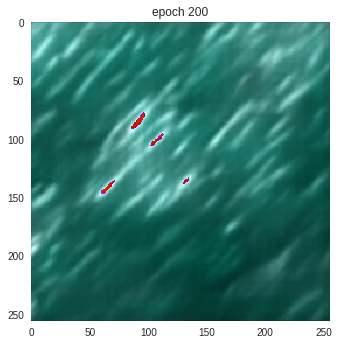

 20%|██        | 201/1000 [05:58<25:46,  1.94s/it]

epoch 201


 20%|██        | 202/1000 [05:59<24:15,  1.82s/it]

epoch 202


 20%|██        | 203/1000 [06:01<23:56,  1.80s/it]

epoch 203


 20%|██        | 204/1000 [06:03<23:44,  1.79s/it]

epoch 204


 20%|██        | 205/1000 [06:04<23:37,  1.78s/it]

epoch 205


 21%|██        | 206/1000 [06:06<23:28,  1.77s/it]

epoch 206


 21%|██        | 207/1000 [06:08<23:24,  1.77s/it]

epoch 207


 21%|██        | 208/1000 [06:10<23:18,  1.77s/it]

epoch 208


 21%|██        | 209/1000 [06:11<23:17,  1.77s/it]

epoch 209


 21%|██        | 210/1000 [06:13<23:12,  1.76s/it]

epoch 210


 21%|██        | 211/1000 [06:15<23:14,  1.77s/it]

epoch 211


 21%|██        | 212/1000 [06:17<23:08,  1.76s/it]

epoch 212


 21%|██▏       | 213/1000 [06:18<23:07,  1.76s/it]

epoch 213


 21%|██▏       | 214/1000 [06:20<23:03,  1.76s/it]

epoch 214


 22%|██▏       | 215/1000 [06:22<23:01,  1.76s/it]

epoch 215


 22%|██▏       | 216/1000 [06:24<22:56,  1.76s/it]

epoch 216


 22%|██▏       | 217/1000 [06:26<22:58,  1.76s/it]

epoch 217


 22%|██▏       | 218/1000 [06:27<22:53,  1.76s/it]

epoch 218


 22%|██▏       | 219/1000 [06:29<22:54,  1.76s/it]

epoch 219


 22%|██▏       | 220/1000 [06:31<22:49,  1.76s/it]

epoch 220


 22%|██▏       | 221/1000 [06:33<22:52,  1.76s/it]

epoch 221


 22%|██▏       | 222/1000 [06:34<22:48,  1.76s/it]

epoch 222


 22%|██▏       | 223/1000 [06:36<22:48,  1.76s/it]

epoch 223


 22%|██▏       | 224/1000 [06:38<22:47,  1.76s/it]

epoch 224


 22%|██▎       | 225/1000 [06:40<22:44,  1.76s/it]

epoch 225


 23%|██▎       | 226/1000 [06:41<22:44,  1.76s/it]

epoch 226


 23%|██▎       | 227/1000 [06:43<22:39,  1.76s/it]

epoch 227


 23%|██▎       | 228/1000 [06:45<22:41,  1.76s/it]

epoch 228


 23%|██▎       | 229/1000 [06:47<22:35,  1.76s/it]

epoch 229


 23%|██▎       | 230/1000 [06:48<22:36,  1.76s/it]

epoch 230


 23%|██▎       | 231/1000 [06:50<22:31,  1.76s/it]

epoch 231


 23%|██▎       | 232/1000 [06:52<22:35,  1.76s/it]

epoch 232


 23%|██▎       | 233/1000 [06:54<22:28,  1.76s/it]

epoch 233


 23%|██▎       | 234/1000 [06:55<22:30,  1.76s/it]

epoch 234


 24%|██▎       | 235/1000 [06:57<22:26,  1.76s/it]

epoch 235


 24%|██▎       | 236/1000 [06:59<22:26,  1.76s/it]

epoch 236


 24%|██▎       | 237/1000 [07:01<22:22,  1.76s/it]

epoch 237


 24%|██▍       | 238/1000 [07:02<22:21,  1.76s/it]

epoch 238


 24%|██▍       | 239/1000 [07:04<22:18,  1.76s/it]

epoch 239


 24%|██▍       | 240/1000 [07:06<22:18,  1.76s/it]

epoch 240


 24%|██▍       | 241/1000 [07:08<22:17,  1.76s/it]

epoch 241


 24%|██▍       | 242/1000 [07:10<22:13,  1.76s/it]

epoch 242


 24%|██▍       | 243/1000 [07:11<22:14,  1.76s/it]

epoch 243


 24%|██▍       | 244/1000 [07:13<22:09,  1.76s/it]

epoch 244


 24%|██▍       | 245/1000 [07:15<22:11,  1.76s/it]

epoch 245


 25%|██▍       | 246/1000 [07:17<22:04,  1.76s/it]

epoch 246


 25%|██▍       | 247/1000 [07:18<22:06,  1.76s/it]

epoch 247


 25%|██▍       | 248/1000 [07:20<22:00,  1.76s/it]

epoch 248


 25%|██▍       | 249/1000 [07:22<22:02,  1.76s/it]

epoch 249


 25%|██▌       | 250/1000 [07:24<21:57,  1.76s/it]

epoch 250


 25%|██▌       | 251/1000 [07:25<21:59,  1.76s/it]

epoch 251


 25%|██▌       | 252/1000 [07:27<21:53,  1.76s/it]

epoch 252


 25%|██▌       | 253/1000 [07:29<21:55,  1.76s/it]

epoch 253


 25%|██▌       | 254/1000 [07:31<21:50,  1.76s/it]

epoch 254


 26%|██▌       | 255/1000 [07:32<21:51,  1.76s/it]

epoch 255


 26%|██▌       | 256/1000 [07:34<21:46,  1.76s/it]

epoch 256


 26%|██▌       | 257/1000 [07:36<21:48,  1.76s/it]

epoch 257


 26%|██▌       | 258/1000 [07:38<21:42,  1.76s/it]

epoch 258


 26%|██▌       | 259/1000 [07:39<21:43,  1.76s/it]

epoch 259


 26%|██▌       | 260/1000 [07:41<21:38,  1.76s/it]

epoch 260


 26%|██▌       | 261/1000 [07:43<21:41,  1.76s/it]

epoch 261


 26%|██▌       | 262/1000 [07:45<21:37,  1.76s/it]

epoch 262


 26%|██▋       | 263/1000 [07:46<21:38,  1.76s/it]

epoch 263


 26%|██▋       | 264/1000 [07:48<21:39,  1.77s/it]

epoch 264


 26%|██▋       | 265/1000 [07:50<21:33,  1.76s/it]

epoch 265


 27%|██▋       | 266/1000 [07:52<21:35,  1.77s/it]

epoch 266


 27%|██▋       | 267/1000 [07:54<21:29,  1.76s/it]

epoch 267


 27%|██▋       | 268/1000 [07:55<21:31,  1.76s/it]

epoch 268


 27%|██▋       | 269/1000 [07:57<21:25,  1.76s/it]

epoch 269


 27%|██▋       | 270/1000 [07:59<21:27,  1.76s/it]

epoch 270


 27%|██▋       | 271/1000 [08:01<21:23,  1.76s/it]

epoch 271


 27%|██▋       | 272/1000 [08:02<21:23,  1.76s/it]

epoch 272


 27%|██▋       | 273/1000 [08:04<21:21,  1.76s/it]

epoch 273


 27%|██▋       | 274/1000 [08:06<21:18,  1.76s/it]

epoch 274


 28%|██▊       | 275/1000 [08:08<21:16,  1.76s/it]

epoch 275


 28%|██▊       | 276/1000 [08:09<21:14,  1.76s/it]

epoch 276


 28%|██▊       | 277/1000 [08:11<21:14,  1.76s/it]

epoch 277


 28%|██▊       | 278/1000 [08:13<21:09,  1.76s/it]

epoch 278


 28%|██▊       | 279/1000 [08:15<21:10,  1.76s/it]

epoch 279


 28%|██▊       | 280/1000 [08:16<21:04,  1.76s/it]

epoch 280


 28%|██▊       | 281/1000 [08:18<21:08,  1.76s/it]

epoch 281


 28%|██▊       | 282/1000 [08:20<21:02,  1.76s/it]

epoch 282


 28%|██▊       | 283/1000 [08:22<21:04,  1.76s/it]

epoch 283


 28%|██▊       | 284/1000 [08:23<20:59,  1.76s/it]

epoch 284


 28%|██▊       | 285/1000 [08:25<20:59,  1.76s/it]

epoch 285


 29%|██▊       | 286/1000 [08:27<20:54,  1.76s/it]

epoch 286


 29%|██▊       | 287/1000 [08:29<20:55,  1.76s/it]

epoch 287


 29%|██▉       | 288/1000 [08:30<20:50,  1.76s/it]

epoch 288


 29%|██▉       | 289/1000 [08:32<20:51,  1.76s/it]

epoch 289


 29%|██▉       | 290/1000 [08:34<20:48,  1.76s/it]

epoch 290


 29%|██▉       | 291/1000 [08:36<20:49,  1.76s/it]

epoch 291


 29%|██▉       | 292/1000 [08:38<20:49,  1.76s/it]

epoch 292


 29%|██▉       | 293/1000 [08:39<20:43,  1.76s/it]

epoch 293


 29%|██▉       | 294/1000 [08:41<20:42,  1.76s/it]

epoch 294


 30%|██▉       | 295/1000 [08:43<20:39,  1.76s/it]

epoch 295


 30%|██▉       | 296/1000 [08:45<20:38,  1.76s/it]

epoch 296


 30%|██▉       | 297/1000 [08:46<20:35,  1.76s/it]

epoch 297


 30%|██▉       | 298/1000 [08:48<20:35,  1.76s/it]

epoch 298


 30%|██▉       | 299/1000 [08:50<20:31,  1.76s/it]

epoch 299


 30%|███       | 300/1000 [08:52<20:31,  1.76s/it]

epoch 300


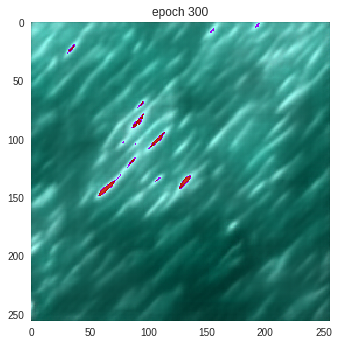

 30%|███       | 301/1000 [08:54<22:23,  1.92s/it]

epoch 301


 30%|███       | 302/1000 [08:55<21:07,  1.82s/it]

epoch 302


 30%|███       | 303/1000 [08:57<20:57,  1.80s/it]

epoch 303


 30%|███       | 304/1000 [08:59<20:44,  1.79s/it]

epoch 304


 30%|███       | 305/1000 [09:01<20:38,  1.78s/it]

epoch 305


 31%|███       | 306/1000 [09:03<20:29,  1.77s/it]

epoch 306


 31%|███       | 307/1000 [09:04<20:27,  1.77s/it]

epoch 307


 31%|███       | 308/1000 [09:06<20:19,  1.76s/it]

epoch 308


 31%|███       | 309/1000 [09:08<20:21,  1.77s/it]

epoch 309


 31%|███       | 310/1000 [09:10<20:16,  1.76s/it]

epoch 310


 31%|███       | 311/1000 [09:11<20:14,  1.76s/it]

epoch 311


 31%|███       | 312/1000 [09:13<20:11,  1.76s/it]

epoch 312


 31%|███▏      | 313/1000 [09:15<20:09,  1.76s/it]

epoch 313


 31%|███▏      | 314/1000 [09:17<20:08,  1.76s/it]

epoch 314


 32%|███▏      | 315/1000 [09:18<20:04,  1.76s/it]

epoch 315


 32%|███▏      | 316/1000 [09:20<20:03,  1.76s/it]

epoch 316


 32%|███▏      | 317/1000 [09:22<19:59,  1.76s/it]

epoch 317


 32%|███▏      | 318/1000 [09:24<19:59,  1.76s/it]

epoch 318


 32%|███▏      | 319/1000 [09:25<19:57,  1.76s/it]

epoch 319


 32%|███▏      | 320/1000 [09:27<19:57,  1.76s/it]

epoch 320


 32%|███▏      | 321/1000 [09:29<19:53,  1.76s/it]

epoch 321


 32%|███▏      | 322/1000 [09:31<19:54,  1.76s/it]

epoch 322


 32%|███▏      | 323/1000 [09:32<19:51,  1.76s/it]

epoch 323


 32%|███▏      | 324/1000 [09:34<19:52,  1.76s/it]

epoch 324


 32%|███▎      | 325/1000 [09:36<19:46,  1.76s/it]

epoch 325


 33%|███▎      | 326/1000 [09:38<19:47,  1.76s/it]

epoch 326


 33%|███▎      | 327/1000 [09:39<19:43,  1.76s/it]

epoch 327


 33%|███▎      | 328/1000 [09:41<19:42,  1.76s/it]

epoch 328


 33%|███▎      | 329/1000 [09:43<19:38,  1.76s/it]

epoch 329


 33%|███▎      | 330/1000 [09:45<19:40,  1.76s/it]

epoch 330


 33%|███▎      | 331/1000 [09:47<19:36,  1.76s/it]

epoch 331


 33%|███▎      | 332/1000 [09:48<19:36,  1.76s/it]

epoch 332


 33%|███▎      | 333/1000 [09:50<19:34,  1.76s/it]

epoch 333


 33%|███▎      | 334/1000 [09:52<19:32,  1.76s/it]

epoch 334


 34%|███▎      | 335/1000 [09:54<19:32,  1.76s/it]

epoch 335


 34%|███▎      | 336/1000 [09:55<19:28,  1.76s/it]

epoch 336


 34%|███▎      | 337/1000 [09:57<19:28,  1.76s/it]

epoch 337


 34%|███▍      | 338/1000 [09:59<19:23,  1.76s/it]

epoch 338


 34%|███▍      | 339/1000 [10:01<19:25,  1.76s/it]

epoch 339


 34%|███▍      | 340/1000 [10:02<19:19,  1.76s/it]

epoch 340


 34%|███▍      | 341/1000 [10:04<19:22,  1.76s/it]

epoch 341


 34%|███▍      | 342/1000 [10:06<19:17,  1.76s/it]

epoch 342


 34%|███▍      | 343/1000 [10:08<19:18,  1.76s/it]

epoch 343


 34%|███▍      | 344/1000 [10:09<19:13,  1.76s/it]

epoch 344


 34%|███▍      | 345/1000 [10:11<19:14,  1.76s/it]

epoch 345


 35%|███▍      | 346/1000 [10:13<19:10,  1.76s/it]

epoch 346


 35%|███▍      | 347/1000 [10:15<19:11,  1.76s/it]

epoch 347


 35%|███▍      | 348/1000 [10:16<19:08,  1.76s/it]

epoch 348


 35%|███▍      | 349/1000 [10:18<19:07,  1.76s/it]

epoch 349


 35%|███▌      | 350/1000 [10:20<19:06,  1.76s/it]

epoch 350


 35%|███▌      | 351/1000 [10:22<19:02,  1.76s/it]

epoch 351


 35%|███▌      | 352/1000 [10:23<19:02,  1.76s/it]

epoch 352


 35%|███▌      | 353/1000 [10:25<18:58,  1.76s/it]

epoch 353


 35%|███▌      | 354/1000 [10:27<18:57,  1.76s/it]

epoch 354


 36%|███▌      | 355/1000 [10:29<18:53,  1.76s/it]

epoch 355


 36%|███▌      | 356/1000 [10:31<18:55,  1.76s/it]

epoch 356


 36%|███▌      | 357/1000 [10:32<18:50,  1.76s/it]

epoch 357


 36%|███▌      | 358/1000 [10:34<18:51,  1.76s/it]

epoch 358


 36%|███▌      | 359/1000 [10:36<18:47,  1.76s/it]

epoch 359


 36%|███▌      | 360/1000 [10:38<18:47,  1.76s/it]

epoch 360


 36%|███▌      | 361/1000 [10:39<18:45,  1.76s/it]

epoch 361


 36%|███▌      | 362/1000 [10:41<18:43,  1.76s/it]

epoch 362


 36%|███▋      | 363/1000 [10:43<18:42,  1.76s/it]

epoch 363


 36%|███▋      | 364/1000 [10:45<18:38,  1.76s/it]

epoch 364


 36%|███▋      | 365/1000 [10:46<18:38,  1.76s/it]

epoch 365


 37%|███▋      | 366/1000 [10:48<18:34,  1.76s/it]

epoch 366


 37%|███▋      | 367/1000 [10:50<18:37,  1.76s/it]

epoch 367


 37%|███▋      | 368/1000 [10:52<18:31,  1.76s/it]

epoch 368


 37%|███▋      | 369/1000 [10:53<18:32,  1.76s/it]

epoch 369


 37%|███▋      | 370/1000 [10:55<18:27,  1.76s/it]

epoch 370


 37%|███▋      | 371/1000 [10:57<18:28,  1.76s/it]

epoch 371


 37%|███▋      | 372/1000 [10:59<18:23,  1.76s/it]

epoch 372


 37%|███▋      | 373/1000 [11:00<18:25,  1.76s/it]

epoch 373


 37%|███▋      | 374/1000 [11:02<18:21,  1.76s/it]

epoch 374


 38%|███▊      | 375/1000 [11:04<18:20,  1.76s/it]

epoch 375


 38%|███▊      | 376/1000 [11:06<18:16,  1.76s/it]

epoch 376


 38%|███▊      | 377/1000 [11:08<18:18,  1.76s/it]

epoch 377


 38%|███▊      | 378/1000 [11:09<18:14,  1.76s/it]

epoch 378


 38%|███▊      | 379/1000 [11:11<18:12,  1.76s/it]

epoch 379


 38%|███▊      | 380/1000 [11:13<18:11,  1.76s/it]

epoch 380


 38%|███▊      | 381/1000 [11:15<18:09,  1.76s/it]

epoch 381


 38%|███▊      | 382/1000 [11:16<18:10,  1.76s/it]

epoch 382


 38%|███▊      | 383/1000 [11:18<18:05,  1.76s/it]

epoch 383


 38%|███▊      | 384/1000 [11:20<18:05,  1.76s/it]

epoch 384


 38%|███▊      | 385/1000 [11:22<18:00,  1.76s/it]

epoch 385


 39%|███▊      | 386/1000 [11:23<18:01,  1.76s/it]

epoch 386


 39%|███▊      | 387/1000 [11:25<17:56,  1.76s/it]

epoch 387


 39%|███▉      | 388/1000 [11:27<17:56,  1.76s/it]

epoch 388


 39%|███▉      | 389/1000 [11:29<17:52,  1.76s/it]

epoch 389


 39%|███▉      | 390/1000 [11:30<17:53,  1.76s/it]

epoch 390


 39%|███▉      | 391/1000 [11:32<17:49,  1.76s/it]

epoch 391


 39%|███▉      | 392/1000 [11:34<17:50,  1.76s/it]

epoch 392


 39%|███▉      | 393/1000 [11:36<17:45,  1.76s/it]

epoch 393


 39%|███▉      | 394/1000 [11:37<17:47,  1.76s/it]

epoch 394


 40%|███▉      | 395/1000 [11:39<17:41,  1.75s/it]

epoch 395


 40%|███▉      | 396/1000 [11:41<17:43,  1.76s/it]

epoch 396


 40%|███▉      | 397/1000 [11:43<17:38,  1.76s/it]

epoch 397


 40%|███▉      | 398/1000 [11:44<17:40,  1.76s/it]

epoch 398


 40%|███▉      | 399/1000 [11:46<17:35,  1.76s/it]

epoch 399


 40%|████      | 400/1000 [11:48<17:36,  1.76s/it]

epoch 400


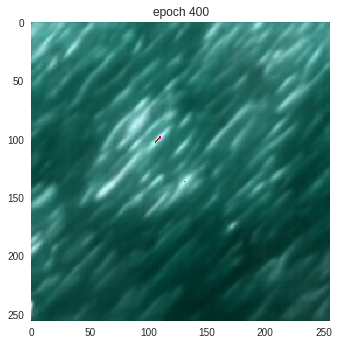

 40%|████      | 401/1000 [11:50<19:12,  1.92s/it]

epoch 401


 40%|████      | 402/1000 [11:52<18:02,  1.81s/it]

epoch 402


 40%|████      | 403/1000 [11:54<17:54,  1.80s/it]

epoch 403


 40%|████      | 404/1000 [11:55<17:44,  1.79s/it]

epoch 404


 40%|████      | 405/1000 [11:57<17:39,  1.78s/it]

epoch 405


 41%|████      | 406/1000 [11:59<17:31,  1.77s/it]

epoch 406


 41%|████      | 407/1000 [12:01<17:30,  1.77s/it]

epoch 407


 41%|████      | 408/1000 [12:02<17:27,  1.77s/it]

epoch 408


 41%|████      | 409/1000 [12:04<17:23,  1.77s/it]

epoch 409


 41%|████      | 410/1000 [12:06<17:22,  1.77s/it]

epoch 410


 41%|████      | 411/1000 [12:08<17:16,  1.76s/it]

epoch 411


 41%|████      | 412/1000 [12:09<17:17,  1.76s/it]

epoch 412


 41%|████▏     | 413/1000 [12:11<17:12,  1.76s/it]

epoch 413


 41%|████▏     | 414/1000 [12:13<17:12,  1.76s/it]

epoch 414


 42%|████▏     | 415/1000 [12:15<17:07,  1.76s/it]

epoch 415


 42%|████▏     | 416/1000 [12:16<17:09,  1.76s/it]

epoch 416


 42%|████▏     | 417/1000 [12:18<17:04,  1.76s/it]

epoch 417


 42%|████▏     | 418/1000 [12:20<17:06,  1.76s/it]

epoch 418


 42%|████▏     | 419/1000 [12:22<17:01,  1.76s/it]

epoch 419


 42%|████▏     | 420/1000 [12:24<17:02,  1.76s/it]

epoch 420


 42%|████▏     | 421/1000 [12:25<16:57,  1.76s/it]

epoch 421


 42%|████▏     | 422/1000 [12:27<16:57,  1.76s/it]

epoch 422


 42%|████▏     | 423/1000 [12:29<16:53,  1.76s/it]

epoch 423


 42%|████▏     | 424/1000 [12:31<16:54,  1.76s/it]

epoch 424


 42%|████▎     | 425/1000 [12:32<16:51,  1.76s/it]

epoch 425


 43%|████▎     | 426/1000 [12:34<16:51,  1.76s/it]

epoch 426


 43%|████▎     | 427/1000 [12:36<16:48,  1.76s/it]

epoch 427


 43%|████▎     | 428/1000 [12:38<16:47,  1.76s/it]

epoch 428


 43%|████▎     | 429/1000 [12:39<16:46,  1.76s/it]

epoch 429


 43%|████▎     | 430/1000 [12:41<16:42,  1.76s/it]

epoch 430


 43%|████▎     | 431/1000 [12:43<16:41,  1.76s/it]

epoch 431


 43%|████▎     | 432/1000 [12:45<16:37,  1.76s/it]

epoch 432


 43%|████▎     | 433/1000 [12:46<16:39,  1.76s/it]

epoch 433


 43%|████▎     | 434/1000 [12:48<16:34,  1.76s/it]

epoch 434


 44%|████▎     | 435/1000 [12:50<16:35,  1.76s/it]

epoch 435


 44%|████▎     | 436/1000 [12:52<16:31,  1.76s/it]

epoch 436


 44%|████▎     | 437/1000 [12:53<16:32,  1.76s/it]

epoch 437


 44%|████▍     | 438/1000 [12:55<16:28,  1.76s/it]

epoch 438


 44%|████▍     | 439/1000 [12:57<16:29,  1.76s/it]

epoch 439


 44%|████▍     | 440/1000 [12:59<16:25,  1.76s/it]

epoch 440


 44%|████▍     | 441/1000 [13:00<16:24,  1.76s/it]

epoch 441


 44%|████▍     | 442/1000 [13:02<16:20,  1.76s/it]

epoch 442


 44%|████▍     | 443/1000 [13:04<16:20,  1.76s/it]

epoch 443


 44%|████▍     | 444/1000 [13:06<16:16,  1.76s/it]

epoch 444


 44%|████▍     | 445/1000 [13:08<16:16,  1.76s/it]

epoch 445


 45%|████▍     | 446/1000 [13:09<16:13,  1.76s/it]

epoch 446


 45%|████▍     | 447/1000 [13:11<16:13,  1.76s/it]

epoch 447


 45%|████▍     | 448/1000 [13:13<16:10,  1.76s/it]

epoch 448


 45%|████▍     | 449/1000 [13:15<16:10,  1.76s/it]

epoch 449


 45%|████▌     | 450/1000 [13:16<16:10,  1.76s/it]

epoch 450


 45%|████▌     | 451/1000 [13:18<16:05,  1.76s/it]

epoch 451


 45%|████▌     | 452/1000 [13:20<16:06,  1.76s/it]

epoch 452


 45%|████▌     | 453/1000 [13:22<16:00,  1.76s/it]

epoch 453


 45%|████▌     | 454/1000 [13:23<16:02,  1.76s/it]

epoch 454


 46%|████▌     | 455/1000 [13:25<15:56,  1.76s/it]

epoch 455


 46%|████▌     | 456/1000 [13:27<15:58,  1.76s/it]

epoch 456


 46%|████▌     | 457/1000 [13:29<15:53,  1.76s/it]

epoch 457


 46%|████▌     | 458/1000 [13:30<15:55,  1.76s/it]

epoch 458


 46%|████▌     | 459/1000 [13:32<15:50,  1.76s/it]

epoch 459


 46%|████▌     | 460/1000 [13:34<15:52,  1.76s/it]

epoch 460


 46%|████▌     | 461/1000 [13:36<15:48,  1.76s/it]

epoch 461


 46%|████▌     | 462/1000 [13:37<15:48,  1.76s/it]

epoch 462


 46%|████▋     | 463/1000 [13:39<15:44,  1.76s/it]

epoch 463


 46%|████▋     | 464/1000 [13:41<15:44,  1.76s/it]

epoch 464


 46%|████▋     | 465/1000 [13:43<15:40,  1.76s/it]

epoch 465


 47%|████▋     | 466/1000 [13:44<15:40,  1.76s/it]

epoch 466


 47%|████▋     | 467/1000 [13:46<15:37,  1.76s/it]

epoch 467


 47%|████▋     | 468/1000 [13:48<15:35,  1.76s/it]

epoch 468


 47%|████▋     | 469/1000 [13:50<15:34,  1.76s/it]

epoch 469


 47%|████▋     | 470/1000 [13:52<15:33,  1.76s/it]

epoch 470


 47%|████▋     | 471/1000 [13:53<15:32,  1.76s/it]

epoch 471


 47%|████▋     | 472/1000 [13:55<15:28,  1.76s/it]

epoch 472


 47%|████▋     | 473/1000 [13:57<15:28,  1.76s/it]

epoch 473


 47%|████▋     | 474/1000 [13:59<15:24,  1.76s/it]

epoch 474


 48%|████▊     | 475/1000 [14:00<15:26,  1.76s/it]

epoch 475


 48%|████▊     | 476/1000 [14:02<15:20,  1.76s/it]

epoch 476


 48%|████▊     | 477/1000 [14:04<15:21,  1.76s/it]

epoch 477


 48%|████▊     | 478/1000 [14:06<15:17,  1.76s/it]

epoch 478


 48%|████▊     | 479/1000 [14:07<15:18,  1.76s/it]

epoch 479


 48%|████▊     | 480/1000 [14:09<15:15,  1.76s/it]

epoch 480


 48%|████▊     | 481/1000 [14:11<15:13,  1.76s/it]

epoch 481


 48%|████▊     | 482/1000 [14:13<15:10,  1.76s/it]

epoch 482


 48%|████▊     | 483/1000 [14:14<15:09,  1.76s/it]

epoch 483


 48%|████▊     | 484/1000 [14:16<15:06,  1.76s/it]

epoch 484


 48%|████▊     | 485/1000 [14:18<15:05,  1.76s/it]

epoch 485


 49%|████▊     | 486/1000 [14:20<15:03,  1.76s/it]

epoch 486


 49%|████▊     | 487/1000 [14:21<15:02,  1.76s/it]

epoch 487


 49%|████▉     | 488/1000 [14:23<15:01,  1.76s/it]

epoch 488


 49%|████▉     | 489/1000 [14:25<14:59,  1.76s/it]

epoch 489


 49%|████▉     | 490/1000 [14:27<14:59,  1.76s/it]

epoch 490


 49%|████▉     | 491/1000 [14:28<14:55,  1.76s/it]

epoch 491


 49%|████▉     | 492/1000 [14:30<14:55,  1.76s/it]

epoch 492


 49%|████▉     | 493/1000 [14:32<14:50,  1.76s/it]

epoch 493


 49%|████▉     | 494/1000 [14:34<14:50,  1.76s/it]

epoch 494


 50%|████▉     | 495/1000 [14:35<14:46,  1.76s/it]

epoch 495


 50%|████▉     | 496/1000 [14:37<14:47,  1.76s/it]

epoch 496


 50%|████▉     | 497/1000 [14:39<14:43,  1.76s/it]

epoch 497


 50%|████▉     | 498/1000 [14:41<14:44,  1.76s/it]

epoch 498


 50%|████▉     | 499/1000 [14:43<14:40,  1.76s/it]

epoch 499


 50%|█████     | 500/1000 [14:44<14:40,  1.76s/it]

epoch 500


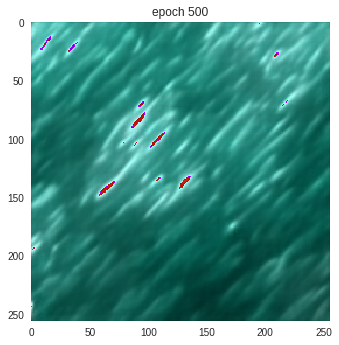

 50%|█████     | 501/1000 [14:47<15:58,  1.92s/it]

epoch 501


 50%|█████     | 502/1000 [14:48<15:02,  1.81s/it]

epoch 502


 50%|█████     | 503/1000 [14:50<14:55,  1.80s/it]

epoch 503


 50%|█████     | 504/1000 [14:52<14:46,  1.79s/it]

epoch 504


 50%|█████     | 505/1000 [14:53<14:40,  1.78s/it]

epoch 505


 51%|█████     | 506/1000 [14:55<14:35,  1.77s/it]

epoch 506


 51%|█████     | 507/1000 [14:57<14:33,  1.77s/it]

epoch 507


 51%|█████     | 508/1000 [14:59<14:30,  1.77s/it]

epoch 508


 51%|█████     | 509/1000 [15:00<14:26,  1.76s/it]

epoch 509


 51%|█████     | 510/1000 [15:02<14:25,  1.77s/it]

epoch 510


 51%|█████     | 511/1000 [15:04<14:20,  1.76s/it]

epoch 511


 51%|█████     | 512/1000 [15:06<14:20,  1.76s/it]

epoch 512


 51%|█████▏    | 513/1000 [15:08<14:16,  1.76s/it]

epoch 513


 51%|█████▏    | 514/1000 [15:09<14:17,  1.76s/it]

epoch 514


 52%|█████▏    | 515/1000 [15:11<14:12,  1.76s/it]

epoch 515


 52%|█████▏    | 516/1000 [15:13<14:13,  1.76s/it]

epoch 516


 52%|█████▏    | 517/1000 [15:15<14:08,  1.76s/it]

epoch 517


 52%|█████▏    | 518/1000 [15:16<14:08,  1.76s/it]

epoch 518


 52%|█████▏    | 519/1000 [15:18<14:04,  1.76s/it]

epoch 519


 52%|█████▏    | 520/1000 [15:20<14:05,  1.76s/it]

epoch 520


 52%|█████▏    | 521/1000 [15:22<14:01,  1.76s/it]

epoch 521


 52%|█████▏    | 522/1000 [15:23<14:01,  1.76s/it]

epoch 522


 52%|█████▏    | 523/1000 [15:25<13:57,  1.76s/it]

epoch 523


 52%|█████▏    | 524/1000 [15:27<13:58,  1.76s/it]

epoch 524


 52%|█████▎    | 525/1000 [15:29<13:54,  1.76s/it]

epoch 525


 53%|█████▎    | 526/1000 [15:30<13:55,  1.76s/it]

epoch 526


 53%|█████▎    | 527/1000 [15:32<13:52,  1.76s/it]

epoch 527


 53%|█████▎    | 528/1000 [15:34<13:52,  1.76s/it]

epoch 528


 53%|█████▎    | 529/1000 [15:36<13:49,  1.76s/it]

epoch 529


 53%|█████▎    | 530/1000 [15:37<13:46,  1.76s/it]

epoch 530


 53%|█████▎    | 531/1000 [15:39<13:44,  1.76s/it]

epoch 531


 53%|█████▎    | 532/1000 [15:41<13:43,  1.76s/it]

epoch 532


 53%|█████▎    | 533/1000 [15:43<13:41,  1.76s/it]

epoch 533


 53%|█████▎    | 534/1000 [15:44<13:40,  1.76s/it]

epoch 534


 54%|█████▎    | 535/1000 [15:46<13:41,  1.77s/it]

epoch 535


 54%|█████▎    | 536/1000 [15:48<13:36,  1.76s/it]

epoch 536


 54%|█████▎    | 537/1000 [15:50<13:37,  1.77s/it]

epoch 537


 54%|█████▍    | 538/1000 [15:52<13:32,  1.76s/it]

epoch 538


 54%|█████▍    | 539/1000 [15:53<13:32,  1.76s/it]

epoch 539


 54%|█████▍    | 540/1000 [15:55<13:27,  1.76s/it]

epoch 540


 54%|█████▍    | 541/1000 [15:57<13:28,  1.76s/it]

epoch 541


 54%|█████▍    | 542/1000 [15:59<13:24,  1.76s/it]

epoch 542


 54%|█████▍    | 543/1000 [16:00<13:25,  1.76s/it]

epoch 543


 54%|█████▍    | 544/1000 [16:02<13:20,  1.76s/it]

epoch 544


 55%|█████▍    | 545/1000 [16:04<13:21,  1.76s/it]

epoch 545


 55%|█████▍    | 546/1000 [16:06<13:18,  1.76s/it]

epoch 546


 55%|█████▍    | 547/1000 [16:07<13:18,  1.76s/it]

epoch 547


 55%|█████▍    | 548/1000 [16:09<13:15,  1.76s/it]

epoch 548


 55%|█████▍    | 549/1000 [16:11<13:13,  1.76s/it]

epoch 549


 55%|█████▌    | 550/1000 [16:13<13:09,  1.76s/it]

epoch 550


 55%|█████▌    | 551/1000 [16:14<13:10,  1.76s/it]

epoch 551


 55%|█████▌    | 552/1000 [16:16<13:07,  1.76s/it]

epoch 552


 55%|█████▌    | 553/1000 [16:18<13:06,  1.76s/it]

epoch 553


 55%|█████▌    | 554/1000 [16:20<13:04,  1.76s/it]

epoch 554


 56%|█████▌    | 555/1000 [16:21<13:03,  1.76s/it]

epoch 555


 56%|█████▌    | 556/1000 [16:23<13:02,  1.76s/it]

epoch 556


 56%|█████▌    | 557/1000 [16:25<12:58,  1.76s/it]

epoch 557


 56%|█████▌    | 558/1000 [16:27<12:59,  1.76s/it]

epoch 558


 56%|█████▌    | 559/1000 [16:28<12:55,  1.76s/it]

epoch 559


 56%|█████▌    | 560/1000 [16:30<12:54,  1.76s/it]

epoch 560


 56%|█████▌    | 561/1000 [16:32<12:50,  1.76s/it]

epoch 561


 56%|█████▌    | 562/1000 [16:34<12:50,  1.76s/it]

epoch 562


 56%|█████▋    | 563/1000 [16:35<12:47,  1.76s/it]

epoch 563


 56%|█████▋    | 564/1000 [16:37<12:47,  1.76s/it]

epoch 564


 56%|█████▋    | 565/1000 [16:39<12:44,  1.76s/it]

epoch 565


 57%|█████▋    | 566/1000 [16:41<12:45,  1.76s/it]

epoch 566


 57%|█████▋    | 567/1000 [16:43<12:42,  1.76s/it]

epoch 567


 57%|█████▋    | 568/1000 [16:44<12:41,  1.76s/it]

epoch 568


 57%|█████▋    | 569/1000 [16:46<12:37,  1.76s/it]

epoch 569


 57%|█████▋    | 570/1000 [16:48<12:37,  1.76s/it]

epoch 570


 57%|█████▋    | 571/1000 [16:50<12:34,  1.76s/it]

epoch 571


 57%|█████▋    | 572/1000 [16:51<12:33,  1.76s/it]

epoch 572


 57%|█████▋    | 573/1000 [16:53<12:30,  1.76s/it]

epoch 573


 57%|█████▋    | 574/1000 [16:55<12:29,  1.76s/it]

epoch 574


 57%|█████▊    | 575/1000 [16:57<12:27,  1.76s/it]

epoch 575


 58%|█████▊    | 576/1000 [16:58<12:25,  1.76s/it]

epoch 576


 58%|█████▊    | 577/1000 [17:00<12:23,  1.76s/it]

epoch 577


 58%|█████▊    | 578/1000 [17:02<12:22,  1.76s/it]

epoch 578


 58%|█████▊    | 579/1000 [17:04<12:20,  1.76s/it]

epoch 579


 58%|█████▊    | 580/1000 [17:05<12:18,  1.76s/it]

epoch 580


 58%|█████▊    | 581/1000 [17:07<12:17,  1.76s/it]

epoch 581


 58%|█████▊    | 582/1000 [17:09<12:14,  1.76s/it]

epoch 582


 58%|█████▊    | 583/1000 [17:11<12:14,  1.76s/it]

epoch 583


 58%|█████▊    | 584/1000 [17:12<12:11,  1.76s/it]

epoch 584


 58%|█████▊    | 585/1000 [17:14<12:11,  1.76s/it]

epoch 585


 59%|█████▊    | 586/1000 [17:16<12:07,  1.76s/it]

epoch 586


 59%|█████▊    | 587/1000 [17:18<12:07,  1.76s/it]

epoch 587


 59%|█████▉    | 588/1000 [17:19<12:03,  1.76s/it]

epoch 588


 59%|█████▉    | 589/1000 [17:21<12:03,  1.76s/it]

epoch 589


 59%|█████▉    | 590/1000 [17:23<12:00,  1.76s/it]

epoch 590


 59%|█████▉    | 591/1000 [17:25<12:01,  1.76s/it]

epoch 591


 59%|█████▉    | 592/1000 [17:27<11:56,  1.76s/it]

epoch 592


 59%|█████▉    | 593/1000 [17:28<11:57,  1.76s/it]

epoch 593


 59%|█████▉    | 594/1000 [17:30<11:53,  1.76s/it]

epoch 594


 60%|█████▉    | 595/1000 [17:32<11:54,  1.76s/it]

epoch 595


 60%|█████▉    | 596/1000 [17:34<11:51,  1.76s/it]

epoch 596


 60%|█████▉    | 597/1000 [17:35<11:49,  1.76s/it]

epoch 597


 60%|█████▉    | 598/1000 [17:37<11:47,  1.76s/it]

epoch 598


 60%|█████▉    | 599/1000 [17:39<11:45,  1.76s/it]

epoch 599


 60%|██████    | 600/1000 [17:41<11:43,  1.76s/it]

epoch 600


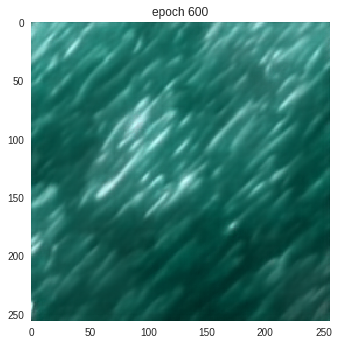

 60%|██████    | 601/1000 [17:43<12:48,  1.93s/it]

epoch 601


 60%|██████    | 602/1000 [17:44<12:02,  1.82s/it]

epoch 602


 60%|██████    | 603/1000 [17:46<11:55,  1.80s/it]

epoch 603


 60%|██████    | 604/1000 [17:48<11:46,  1.79s/it]

epoch 604


 60%|██████    | 605/1000 [17:50<11:44,  1.78s/it]

epoch 605


 61%|██████    | 606/1000 [17:52<11:37,  1.77s/it]

epoch 606


 61%|██████    | 607/1000 [17:53<11:36,  1.77s/it]

epoch 607


 61%|██████    | 608/1000 [17:55<11:31,  1.76s/it]

epoch 608


 61%|██████    | 609/1000 [17:57<11:31,  1.77s/it]

epoch 609


 61%|██████    | 610/1000 [17:59<11:26,  1.76s/it]

epoch 610


 61%|██████    | 611/1000 [18:00<11:26,  1.76s/it]

epoch 611


 61%|██████    | 612/1000 [18:02<11:22,  1.76s/it]

epoch 612


 61%|██████▏   | 613/1000 [18:04<11:22,  1.76s/it]

epoch 613


 61%|██████▏   | 614/1000 [18:06<11:20,  1.76s/it]

epoch 614


 62%|██████▏   | 615/1000 [18:07<11:18,  1.76s/it]

epoch 615


 62%|██████▏   | 616/1000 [18:09<11:16,  1.76s/it]

epoch 616


 62%|██████▏   | 617/1000 [18:11<11:14,  1.76s/it]

epoch 617


 62%|██████▏   | 618/1000 [18:13<11:12,  1.76s/it]

epoch 618


 62%|██████▏   | 619/1000 [18:14<11:10,  1.76s/it]

epoch 619


 62%|██████▏   | 620/1000 [18:16<11:10,  1.76s/it]

epoch 620


 62%|██████▏   | 621/1000 [18:18<11:06,  1.76s/it]

epoch 621


 62%|██████▏   | 622/1000 [18:20<11:07,  1.77s/it]

epoch 622


 62%|██████▏   | 623/1000 [18:21<11:03,  1.76s/it]

epoch 623


 62%|██████▏   | 624/1000 [18:23<11:02,  1.76s/it]

epoch 624


 62%|██████▎   | 625/1000 [18:25<10:58,  1.76s/it]

epoch 625


 63%|██████▎   | 626/1000 [18:27<10:59,  1.76s/it]

epoch 626


 63%|██████▎   | 627/1000 [18:29<10:56,  1.76s/it]

epoch 627


 63%|██████▎   | 628/1000 [18:30<10:55,  1.76s/it]

epoch 628


 63%|██████▎   | 629/1000 [18:32<10:53,  1.76s/it]

epoch 629


 63%|██████▎   | 630/1000 [18:34<10:51,  1.76s/it]

epoch 630


 63%|██████▎   | 631/1000 [18:36<10:51,  1.76s/it]

epoch 631


 63%|██████▎   | 632/1000 [18:37<10:47,  1.76s/it]

epoch 632


 63%|██████▎   | 633/1000 [18:39<10:47,  1.76s/it]

epoch 633


 63%|██████▎   | 634/1000 [18:41<10:43,  1.76s/it]

epoch 634


 64%|██████▎   | 635/1000 [18:43<10:43,  1.76s/it]

epoch 635


 64%|██████▎   | 636/1000 [18:44<10:39,  1.76s/it]

epoch 636


 64%|██████▎   | 637/1000 [18:46<10:39,  1.76s/it]

epoch 637


 64%|██████▍   | 638/1000 [18:48<10:36,  1.76s/it]

epoch 638


 64%|██████▍   | 639/1000 [18:50<10:35,  1.76s/it]

epoch 639


 64%|██████▍   | 640/1000 [18:51<10:31,  1.76s/it]

epoch 640


 64%|██████▍   | 641/1000 [18:53<10:33,  1.76s/it]

epoch 641


 64%|██████▍   | 642/1000 [18:55<10:29,  1.76s/it]

epoch 642


 64%|██████▍   | 643/1000 [18:57<10:29,  1.76s/it]

epoch 643


 64%|██████▍   | 644/1000 [18:58<10:26,  1.76s/it]

epoch 644


 64%|██████▍   | 645/1000 [19:00<10:25,  1.76s/it]

epoch 645


 65%|██████▍   | 646/1000 [19:02<10:23,  1.76s/it]

epoch 646


 65%|██████▍   | 647/1000 [19:04<10:20,  1.76s/it]

epoch 647


 65%|██████▍   | 648/1000 [19:05<10:19,  1.76s/it]

epoch 648


 65%|██████▍   | 649/1000 [19:07<10:17,  1.76s/it]

epoch 649


 65%|██████▌   | 650/1000 [19:09<10:15,  1.76s/it]

epoch 650


 65%|██████▌   | 651/1000 [19:11<10:13,  1.76s/it]

epoch 651


 65%|██████▌   | 652/1000 [19:13<10:12,  1.76s/it]

epoch 652


 65%|██████▌   | 653/1000 [19:14<10:09,  1.76s/it]

epoch 653


 65%|██████▌   | 654/1000 [19:16<10:09,  1.76s/it]

epoch 654


 66%|██████▌   | 655/1000 [19:18<10:05,  1.76s/it]

epoch 655


 66%|██████▌   | 656/1000 [19:20<10:05,  1.76s/it]

epoch 656


 66%|██████▌   | 657/1000 [19:21<10:01,  1.76s/it]

epoch 657


 66%|██████▌   | 658/1000 [19:23<10:02,  1.76s/it]

epoch 658


 66%|██████▌   | 659/1000 [19:25<09:58,  1.76s/it]

epoch 659


 66%|██████▌   | 660/1000 [19:27<09:59,  1.76s/it]

epoch 660


 66%|██████▌   | 661/1000 [19:28<09:55,  1.76s/it]

epoch 661


 66%|██████▌   | 662/1000 [19:30<09:55,  1.76s/it]

epoch 662


 66%|██████▋   | 663/1000 [19:32<09:53,  1.76s/it]

epoch 663


 66%|██████▋   | 664/1000 [19:34<09:52,  1.76s/it]

epoch 664


 66%|██████▋   | 665/1000 [19:35<09:49,  1.76s/it]

epoch 665


 67%|██████▋   | 666/1000 [19:37<09:48,  1.76s/it]

epoch 666


 67%|██████▋   | 667/1000 [19:39<09:46,  1.76s/it]

epoch 667


 67%|██████▋   | 668/1000 [19:41<09:44,  1.76s/it]

epoch 668


 67%|██████▋   | 669/1000 [19:42<09:42,  1.76s/it]

epoch 669


 67%|██████▋   | 670/1000 [19:44<09:40,  1.76s/it]

epoch 670


 67%|██████▋   | 671/1000 [19:46<09:38,  1.76s/it]

epoch 671


 67%|██████▋   | 672/1000 [19:48<09:36,  1.76s/it]

epoch 672


 67%|██████▋   | 673/1000 [19:49<09:35,  1.76s/it]

epoch 673


 67%|██████▋   | 674/1000 [19:51<09:33,  1.76s/it]

epoch 674


 68%|██████▊   | 675/1000 [19:53<09:32,  1.76s/it]

epoch 675


 68%|██████▊   | 676/1000 [19:55<09:29,  1.76s/it]

epoch 676


 68%|██████▊   | 677/1000 [19:57<09:29,  1.76s/it]

epoch 677


 68%|██████▊   | 678/1000 [19:58<09:25,  1.76s/it]

epoch 678


 68%|██████▊   | 679/1000 [20:00<09:25,  1.76s/it]

epoch 679


 68%|██████▊   | 680/1000 [20:02<09:21,  1.76s/it]

epoch 680


 68%|██████▊   | 681/1000 [20:04<09:21,  1.76s/it]

epoch 681


 68%|██████▊   | 682/1000 [20:05<09:19,  1.76s/it]

epoch 682


 68%|██████▊   | 683/1000 [20:07<09:18,  1.76s/it]

epoch 683


 68%|██████▊   | 684/1000 [20:09<09:15,  1.76s/it]

epoch 684


 68%|██████▊   | 685/1000 [20:11<09:14,  1.76s/it]

epoch 685


 69%|██████▊   | 686/1000 [20:12<09:11,  1.76s/it]

epoch 686


 69%|██████▊   | 687/1000 [20:14<09:10,  1.76s/it]

epoch 687


 69%|██████▉   | 688/1000 [20:16<09:08,  1.76s/it]

epoch 688


 69%|██████▉   | 689/1000 [20:18<09:07,  1.76s/it]

epoch 689


 69%|██████▉   | 690/1000 [20:19<09:05,  1.76s/it]

epoch 690


 69%|██████▉   | 691/1000 [20:21<09:03,  1.76s/it]

epoch 691


 69%|██████▉   | 692/1000 [20:23<09:01,  1.76s/it]

epoch 692


 69%|██████▉   | 693/1000 [20:25<08:59,  1.76s/it]

epoch 693


 69%|██████▉   | 694/1000 [20:26<08:59,  1.76s/it]

epoch 694


 70%|██████▉   | 695/1000 [20:28<08:56,  1.76s/it]

epoch 695


 70%|██████▉   | 696/1000 [20:30<08:55,  1.76s/it]

epoch 696


 70%|██████▉   | 697/1000 [20:32<08:52,  1.76s/it]

epoch 697


 70%|██████▉   | 698/1000 [20:33<08:51,  1.76s/it]

epoch 698


 70%|██████▉   | 699/1000 [20:35<08:49,  1.76s/it]

epoch 699


 70%|███████   | 700/1000 [20:37<08:48,  1.76s/it]

epoch 700


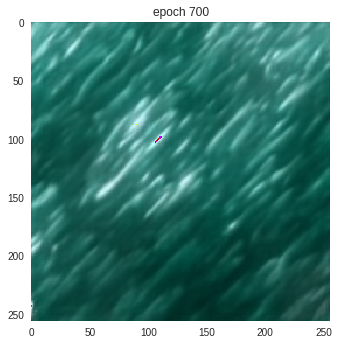

 70%|███████   | 701/1000 [20:39<09:39,  1.94s/it]

epoch 701


 70%|███████   | 702/1000 [20:41<09:03,  1.82s/it]

epoch 702


 70%|███████   | 703/1000 [20:43<08:55,  1.80s/it]

epoch 703


 70%|███████   | 704/1000 [20:44<08:51,  1.80s/it]

epoch 704


 70%|███████   | 705/1000 [20:46<08:44,  1.78s/it]

epoch 705


 71%|███████   | 706/1000 [20:48<08:42,  1.78s/it]

epoch 706


 71%|███████   | 707/1000 [20:50<08:38,  1.77s/it]

epoch 707


 71%|███████   | 708/1000 [20:51<08:36,  1.77s/it]

epoch 708


 71%|███████   | 709/1000 [20:53<08:32,  1.76s/it]

epoch 709


 71%|███████   | 710/1000 [20:55<08:32,  1.77s/it]

epoch 710


 71%|███████   | 711/1000 [20:57<08:28,  1.76s/it]

epoch 711


 71%|███████   | 712/1000 [20:58<08:28,  1.76s/it]

epoch 712


 71%|███████▏  | 713/1000 [21:00<08:25,  1.76s/it]

epoch 713


 71%|███████▏  | 714/1000 [21:02<08:24,  1.76s/it]

epoch 714


 72%|███████▏  | 715/1000 [21:04<08:22,  1.76s/it]

epoch 715


 72%|███████▏  | 716/1000 [21:06<08:20,  1.76s/it]

epoch 716


 72%|███████▏  | 717/1000 [21:07<08:18,  1.76s/it]

epoch 717


 72%|███████▏  | 718/1000 [21:09<08:15,  1.76s/it]

epoch 718


 72%|███████▏  | 719/1000 [21:11<08:13,  1.76s/it]

epoch 719


 72%|███████▏  | 720/1000 [21:13<08:12,  1.76s/it]

epoch 720


 72%|███████▏  | 721/1000 [21:14<08:11,  1.76s/it]

epoch 721


 72%|███████▏  | 722/1000 [21:16<08:08,  1.76s/it]

epoch 722


 72%|███████▏  | 723/1000 [21:18<08:07,  1.76s/it]

epoch 723


 72%|███████▏  | 724/1000 [21:20<08:05,  1.76s/it]

epoch 724


 72%|███████▎  | 725/1000 [21:21<08:04,  1.76s/it]

epoch 725


 73%|███████▎  | 726/1000 [21:23<08:01,  1.76s/it]

epoch 726


 73%|███████▎  | 727/1000 [21:25<08:00,  1.76s/it]

epoch 727


 73%|███████▎  | 728/1000 [21:27<07:57,  1.76s/it]

epoch 728


 73%|███████▎  | 729/1000 [21:28<07:57,  1.76s/it]

epoch 729


 73%|███████▎  | 730/1000 [21:30<07:54,  1.76s/it]

epoch 730


 73%|███████▎  | 731/1000 [21:32<07:53,  1.76s/it]

epoch 731


 73%|███████▎  | 732/1000 [21:34<07:50,  1.76s/it]

epoch 732


 73%|███████▎  | 733/1000 [21:35<07:50,  1.76s/it]

epoch 733


 73%|███████▎  | 734/1000 [21:37<07:47,  1.76s/it]

epoch 734


 74%|███████▎  | 735/1000 [21:39<07:46,  1.76s/it]

epoch 735


 74%|███████▎  | 736/1000 [21:41<07:43,  1.76s/it]

epoch 736


 74%|███████▎  | 737/1000 [21:42<07:42,  1.76s/it]

epoch 737


 74%|███████▍  | 738/1000 [21:44<07:41,  1.76s/it]

epoch 738


 74%|███████▍  | 739/1000 [21:46<07:39,  1.76s/it]

epoch 739


 74%|███████▍  | 740/1000 [21:48<07:37,  1.76s/it]

epoch 740


 74%|███████▍  | 741/1000 [21:50<07:35,  1.76s/it]

epoch 741


 74%|███████▍  | 742/1000 [21:51<07:35,  1.77s/it]

epoch 742


 74%|███████▍  | 743/1000 [21:53<07:31,  1.76s/it]

epoch 743


 74%|███████▍  | 744/1000 [21:55<07:31,  1.77s/it]

epoch 744


 74%|███████▍  | 745/1000 [21:57<07:28,  1.76s/it]

epoch 745


 75%|███████▍  | 746/1000 [21:58<07:27,  1.76s/it]

epoch 746


 75%|███████▍  | 747/1000 [22:00<07:24,  1.76s/it]

epoch 747


 75%|███████▍  | 748/1000 [22:02<07:24,  1.76s/it]

epoch 748


 75%|███████▍  | 749/1000 [22:04<07:21,  1.76s/it]

epoch 749


 75%|███████▌  | 750/1000 [22:05<07:21,  1.77s/it]

epoch 750


 75%|███████▌  | 751/1000 [22:07<07:19,  1.76s/it]

epoch 751


 75%|███████▌  | 752/1000 [22:09<07:17,  1.76s/it]

epoch 752


 75%|███████▌  | 753/1000 [22:11<07:15,  1.76s/it]

epoch 753


 75%|███████▌  | 754/1000 [22:12<07:13,  1.76s/it]

epoch 754


 76%|███████▌  | 755/1000 [22:14<07:12,  1.76s/it]

epoch 755


 76%|███████▌  | 756/1000 [22:16<07:09,  1.76s/it]

epoch 756


 76%|███████▌  | 757/1000 [22:18<07:08,  1.76s/it]

epoch 757


 76%|███████▌  | 758/1000 [22:19<07:05,  1.76s/it]

epoch 758


 76%|███████▌  | 759/1000 [22:21<07:04,  1.76s/it]

epoch 759


 76%|███████▌  | 760/1000 [22:23<07:01,  1.76s/it]

epoch 760


 76%|███████▌  | 761/1000 [22:25<07:01,  1.76s/it]

epoch 761


 76%|███████▌  | 762/1000 [22:27<06:58,  1.76s/it]

epoch 762


 76%|███████▋  | 763/1000 [22:28<06:57,  1.76s/it]

epoch 763


 76%|███████▋  | 764/1000 [22:30<06:54,  1.76s/it]

epoch 764


 76%|███████▋  | 765/1000 [22:32<06:53,  1.76s/it]

epoch 765


 77%|███████▋  | 766/1000 [22:34<06:50,  1.76s/it]

epoch 766


 77%|███████▋  | 767/1000 [22:35<06:49,  1.76s/it]

epoch 767


 77%|███████▋  | 768/1000 [22:37<06:47,  1.76s/it]

epoch 768


 77%|███████▋  | 769/1000 [22:39<06:46,  1.76s/it]

epoch 769


 77%|███████▋  | 770/1000 [22:41<06:44,  1.76s/it]

epoch 770


 77%|███████▋  | 771/1000 [22:42<06:43,  1.76s/it]

epoch 771


 77%|███████▋  | 772/1000 [22:44<06:41,  1.76s/it]

epoch 772


 77%|███████▋  | 773/1000 [22:46<06:39,  1.76s/it]

epoch 773


 77%|███████▋  | 774/1000 [22:48<06:38,  1.76s/it]

epoch 774


 78%|███████▊  | 775/1000 [22:49<06:35,  1.76s/it]

epoch 775


 78%|███████▊  | 776/1000 [22:51<06:34,  1.76s/it]

epoch 776


 78%|███████▊  | 777/1000 [22:53<06:31,  1.76s/it]

epoch 777


 78%|███████▊  | 778/1000 [22:55<06:31,  1.76s/it]

epoch 778


 78%|███████▊  | 779/1000 [22:56<06:28,  1.76s/it]

epoch 779


 78%|███████▊  | 780/1000 [22:58<06:27,  1.76s/it]

epoch 780


 78%|███████▊  | 781/1000 [23:00<06:24,  1.76s/it]

epoch 781


 78%|███████▊  | 782/1000 [23:02<06:24,  1.76s/it]

epoch 782


 78%|███████▊  | 783/1000 [23:03<06:21,  1.76s/it]

epoch 783


 78%|███████▊  | 784/1000 [23:05<06:20,  1.76s/it]

epoch 784


 78%|███████▊  | 785/1000 [23:07<06:17,  1.76s/it]

epoch 785


 79%|███████▊  | 786/1000 [23:09<06:16,  1.76s/it]

epoch 786


 79%|███████▊  | 787/1000 [23:10<06:14,  1.76s/it]

epoch 787


 79%|███████▉  | 788/1000 [23:12<06:13,  1.76s/it]

epoch 788


 79%|███████▉  | 789/1000 [23:14<06:10,  1.76s/it]

epoch 789


 79%|███████▉  | 790/1000 [23:16<06:09,  1.76s/it]

epoch 790


 79%|███████▉  | 791/1000 [23:18<06:07,  1.76s/it]

epoch 791


 79%|███████▉  | 792/1000 [23:19<06:06,  1.76s/it]

epoch 792


 79%|███████▉  | 793/1000 [23:21<06:04,  1.76s/it]

epoch 793


 79%|███████▉  | 794/1000 [23:23<06:02,  1.76s/it]

epoch 794


 80%|███████▉  | 795/1000 [23:25<06:01,  1.76s/it]

epoch 795


 80%|███████▉  | 796/1000 [23:26<05:58,  1.76s/it]

epoch 796


 80%|███████▉  | 797/1000 [23:28<05:57,  1.76s/it]

epoch 797


 80%|███████▉  | 798/1000 [23:30<05:54,  1.76s/it]

epoch 798


 80%|███████▉  | 799/1000 [23:32<05:54,  1.76s/it]

epoch 799


 80%|████████  | 800/1000 [23:33<05:51,  1.76s/it]

epoch 800


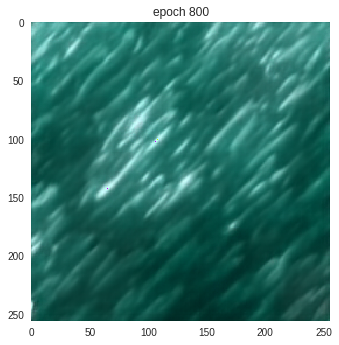

 80%|████████  | 801/1000 [23:36<06:23,  1.93s/it]

epoch 801


 80%|████████  | 802/1000 [23:37<05:58,  1.81s/it]

epoch 802


 80%|████████  | 803/1000 [23:39<05:53,  1.79s/it]

epoch 803


 80%|████████  | 804/1000 [23:41<05:49,  1.78s/it]

epoch 804


 80%|████████  | 805/1000 [23:43<05:45,  1.77s/it]

epoch 805


 81%|████████  | 806/1000 [23:44<05:44,  1.77s/it]

epoch 806


 81%|████████  | 807/1000 [23:46<05:40,  1.77s/it]

epoch 807


 81%|████████  | 808/1000 [23:48<05:39,  1.77s/it]

epoch 808


 81%|████████  | 809/1000 [23:50<05:36,  1.76s/it]

epoch 809


 81%|████████  | 810/1000 [23:51<05:35,  1.77s/it]

epoch 810


 81%|████████  | 811/1000 [23:53<05:32,  1.76s/it]

epoch 811


 81%|████████  | 812/1000 [23:55<05:31,  1.76s/it]

epoch 812


 81%|████████▏ | 813/1000 [23:57<05:29,  1.76s/it]

epoch 813


 81%|████████▏ | 814/1000 [23:58<05:27,  1.76s/it]

epoch 814


 82%|████████▏ | 815/1000 [24:00<05:25,  1.76s/it]

epoch 815


 82%|████████▏ | 816/1000 [24:02<05:23,  1.76s/it]

epoch 816


 82%|████████▏ | 817/1000 [24:04<05:21,  1.76s/it]

epoch 817


 82%|████████▏ | 818/1000 [24:05<05:20,  1.76s/it]

epoch 818


 82%|████████▏ | 819/1000 [24:07<05:18,  1.76s/it]

epoch 819


 82%|████████▏ | 820/1000 [24:09<05:16,  1.76s/it]

epoch 820


 82%|████████▏ | 821/1000 [24:11<05:15,  1.76s/it]

epoch 821


 82%|████████▏ | 822/1000 [24:12<05:13,  1.76s/it]

epoch 822


 82%|████████▏ | 823/1000 [24:14<05:12,  1.77s/it]

epoch 823


 82%|████████▏ | 824/1000 [24:16<05:09,  1.76s/it]

epoch 824


 82%|████████▎ | 825/1000 [24:18<05:08,  1.76s/it]

epoch 825


 83%|████████▎ | 826/1000 [24:19<05:05,  1.76s/it]

epoch 826


 83%|████████▎ | 827/1000 [24:21<05:04,  1.76s/it]

epoch 827


 83%|████████▎ | 828/1000 [24:23<05:02,  1.76s/it]

epoch 828


 83%|████████▎ | 829/1000 [24:25<05:01,  1.76s/it]

epoch 829


 83%|████████▎ | 830/1000 [24:26<04:58,  1.76s/it]

epoch 830


 83%|████████▎ | 831/1000 [24:28<04:57,  1.76s/it]

epoch 831


 83%|████████▎ | 832/1000 [24:30<04:55,  1.76s/it]

epoch 832


 83%|████████▎ | 833/1000 [24:32<04:54,  1.76s/it]

epoch 833


 83%|████████▎ | 834/1000 [24:34<04:51,  1.76s/it]

epoch 834


 84%|████████▎ | 835/1000 [24:35<04:50,  1.76s/it]

epoch 835


 84%|████████▎ | 836/1000 [24:37<04:48,  1.76s/it]

epoch 836


 84%|████████▎ | 837/1000 [24:39<04:47,  1.76s/it]

epoch 837


 84%|████████▍ | 838/1000 [24:41<04:44,  1.76s/it]

epoch 838


 84%|████████▍ | 839/1000 [24:42<04:43,  1.76s/it]

epoch 839


 84%|████████▍ | 840/1000 [24:44<04:42,  1.76s/it]

epoch 840


 84%|████████▍ | 841/1000 [24:46<04:39,  1.76s/it]

epoch 841


 84%|████████▍ | 842/1000 [24:48<04:39,  1.77s/it]

epoch 842


 84%|████████▍ | 843/1000 [24:49<04:36,  1.76s/it]

epoch 843


 84%|████████▍ | 844/1000 [24:51<04:35,  1.77s/it]

epoch 844


 84%|████████▍ | 845/1000 [24:53<04:32,  1.76s/it]

epoch 845


 85%|████████▍ | 846/1000 [24:55<04:31,  1.76s/it]

epoch 846


 85%|████████▍ | 847/1000 [24:56<04:29,  1.76s/it]

epoch 847


 85%|████████▍ | 848/1000 [24:58<04:27,  1.76s/it]

epoch 848


 85%|████████▍ | 849/1000 [25:00<04:26,  1.76s/it]

epoch 849


 85%|████████▌ | 850/1000 [25:02<04:24,  1.76s/it]

epoch 850


 85%|████████▌ | 851/1000 [25:04<04:23,  1.77s/it]

epoch 851


 85%|████████▌ | 852/1000 [25:05<04:20,  1.76s/it]

epoch 852


 85%|████████▌ | 853/1000 [25:07<04:19,  1.76s/it]

epoch 853


 85%|████████▌ | 854/1000 [25:09<04:16,  1.76s/it]

epoch 854


 86%|████████▌ | 855/1000 [25:11<04:15,  1.76s/it]

epoch 855


 86%|████████▌ | 856/1000 [25:12<04:12,  1.76s/it]

epoch 856


 86%|████████▌ | 857/1000 [25:14<04:11,  1.76s/it]

epoch 857


 86%|████████▌ | 858/1000 [25:16<04:09,  1.76s/it]

epoch 858


 86%|████████▌ | 859/1000 [25:18<04:08,  1.76s/it]

epoch 859


 86%|████████▌ | 860/1000 [25:19<04:05,  1.76s/it]

epoch 860


 86%|████████▌ | 861/1000 [25:21<04:04,  1.76s/it]

epoch 861


 86%|████████▌ | 862/1000 [25:23<04:02,  1.76s/it]

epoch 862


 86%|████████▋ | 863/1000 [25:25<04:01,  1.76s/it]

epoch 863


 86%|████████▋ | 864/1000 [25:26<03:59,  1.76s/it]

epoch 864


 86%|████████▋ | 865/1000 [25:28<03:57,  1.76s/it]

epoch 865


 87%|████████▋ | 866/1000 [25:30<03:55,  1.76s/it]

epoch 866


 87%|████████▋ | 867/1000 [25:32<03:54,  1.76s/it]

epoch 867


 87%|████████▋ | 868/1000 [25:33<03:52,  1.76s/it]

epoch 868


 87%|████████▋ | 869/1000 [25:35<03:50,  1.76s/it]

epoch 869


 87%|████████▋ | 870/1000 [25:37<03:49,  1.77s/it]

epoch 870


 87%|████████▋ | 871/1000 [25:39<03:47,  1.76s/it]

epoch 871


 87%|████████▋ | 872/1000 [25:40<03:46,  1.77s/it]

epoch 872


 87%|████████▋ | 873/1000 [25:42<03:43,  1.76s/it]

epoch 873


 87%|████████▋ | 874/1000 [25:44<03:42,  1.76s/it]

epoch 874


 88%|████████▊ | 875/1000 [25:46<03:39,  1.76s/it]

epoch 875


 88%|████████▊ | 876/1000 [25:48<03:38,  1.76s/it]

epoch 876


 88%|████████▊ | 877/1000 [25:49<03:36,  1.76s/it]

epoch 877


 88%|████████▊ | 878/1000 [25:51<03:34,  1.76s/it]

epoch 878


 88%|████████▊ | 879/1000 [25:53<03:32,  1.76s/it]

epoch 879


 88%|████████▊ | 880/1000 [25:55<03:31,  1.76s/it]

epoch 880


 88%|████████▊ | 881/1000 [25:56<03:29,  1.76s/it]

epoch 881


 88%|████████▊ | 882/1000 [25:58<03:27,  1.76s/it]

epoch 882


 88%|████████▊ | 883/1000 [26:00<03:26,  1.76s/it]

epoch 883


 88%|████████▊ | 884/1000 [26:02<03:24,  1.76s/it]

epoch 884


 88%|████████▊ | 885/1000 [26:03<03:22,  1.76s/it]

epoch 885


 89%|████████▊ | 886/1000 [26:05<03:20,  1.76s/it]

epoch 886


 89%|████████▊ | 887/1000 [26:07<03:18,  1.76s/it]

epoch 887


 89%|████████▉ | 888/1000 [26:09<03:17,  1.76s/it]

epoch 888


 89%|████████▉ | 889/1000 [26:10<03:15,  1.76s/it]

epoch 889


 89%|████████▉ | 890/1000 [26:12<03:13,  1.76s/it]

epoch 890


 89%|████████▉ | 891/1000 [26:14<03:12,  1.77s/it]

epoch 891


 89%|████████▉ | 892/1000 [26:16<03:09,  1.76s/it]

epoch 892


 89%|████████▉ | 893/1000 [26:17<03:08,  1.76s/it]

epoch 893


 89%|████████▉ | 894/1000 [26:19<03:06,  1.76s/it]

epoch 894


 90%|████████▉ | 895/1000 [26:21<03:04,  1.76s/it]

epoch 895


 90%|████████▉ | 896/1000 [26:23<03:02,  1.76s/it]

epoch 896


 90%|████████▉ | 897/1000 [26:24<03:01,  1.76s/it]

epoch 897


 90%|████████▉ | 898/1000 [26:26<02:59,  1.76s/it]

epoch 898


 90%|████████▉ | 899/1000 [26:28<02:58,  1.76s/it]

epoch 899


 90%|█████████ | 900/1000 [26:30<02:55,  1.76s/it]

epoch 900


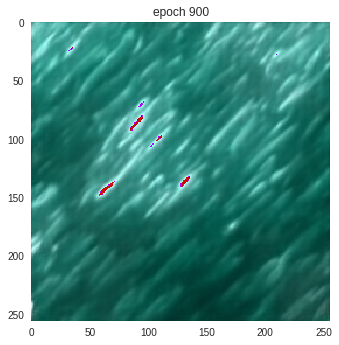

 90%|█████████ | 901/1000 [26:32<03:11,  1.94s/it]

epoch 901


 90%|█████████ | 902/1000 [26:34<02:58,  1.82s/it]

epoch 902


 90%|█████████ | 903/1000 [26:35<02:55,  1.81s/it]

epoch 903


 90%|█████████ | 904/1000 [26:37<02:51,  1.79s/it]

epoch 904


 90%|█████████ | 905/1000 [26:39<02:49,  1.78s/it]

epoch 905


 91%|█████████ | 906/1000 [26:41<02:46,  1.77s/it]

epoch 906


 91%|█████████ | 907/1000 [26:42<02:44,  1.77s/it]

epoch 907


 91%|█████████ | 908/1000 [26:44<02:42,  1.76s/it]

epoch 908


 91%|█████████ | 909/1000 [26:46<02:40,  1.77s/it]

epoch 909


 91%|█████████ | 910/1000 [26:48<02:38,  1.76s/it]

epoch 910


 91%|█████████ | 911/1000 [26:49<02:37,  1.77s/it]

epoch 911


 91%|█████████ | 912/1000 [26:51<02:35,  1.77s/it]

epoch 912


 91%|█████████▏| 913/1000 [26:53<02:33,  1.76s/it]

epoch 913


 91%|█████████▏| 914/1000 [26:55<02:31,  1.76s/it]

epoch 914


 92%|█████████▏| 915/1000 [26:57<02:29,  1.76s/it]

epoch 915


 92%|█████████▏| 916/1000 [26:58<02:27,  1.76s/it]

epoch 916


 92%|█████████▏| 917/1000 [27:00<02:25,  1.76s/it]

epoch 917


 92%|█████████▏| 918/1000 [27:02<02:24,  1.76s/it]

epoch 918


 92%|█████████▏| 919/1000 [27:04<02:22,  1.76s/it]

epoch 919


 92%|█████████▏| 920/1000 [27:05<02:21,  1.76s/it]

epoch 920


 92%|█████████▏| 921/1000 [27:07<02:18,  1.76s/it]

epoch 921


 92%|█████████▏| 922/1000 [27:09<02:17,  1.76s/it]

epoch 922


 92%|█████████▏| 923/1000 [27:11<02:15,  1.76s/it]

epoch 923


 92%|█████████▏| 924/1000 [27:12<02:13,  1.76s/it]

epoch 924


 92%|█████████▎| 925/1000 [27:14<02:11,  1.76s/it]

epoch 925


 93%|█████████▎| 926/1000 [27:16<02:10,  1.76s/it]

epoch 926


 93%|█████████▎| 927/1000 [27:18<02:08,  1.76s/it]

epoch 927


 93%|█████████▎| 928/1000 [27:19<02:06,  1.76s/it]

epoch 928


 93%|█████████▎| 929/1000 [27:21<02:04,  1.76s/it]

epoch 929


 93%|█████████▎| 930/1000 [27:23<02:03,  1.76s/it]

epoch 930


 93%|█████████▎| 931/1000 [27:25<02:01,  1.76s/it]

epoch 931


 93%|█████████▎| 932/1000 [27:26<01:59,  1.76s/it]

epoch 932


 93%|█████████▎| 933/1000 [27:28<01:58,  1.76s/it]

epoch 933


 93%|█████████▎| 934/1000 [27:30<01:56,  1.76s/it]

epoch 934


 94%|█████████▎| 935/1000 [27:32<01:54,  1.76s/it]

epoch 935


 94%|█████████▎| 936/1000 [27:33<01:52,  1.76s/it]

epoch 936


 94%|█████████▎| 937/1000 [27:35<01:51,  1.76s/it]

epoch 937


 94%|█████████▍| 938/1000 [27:37<01:48,  1.76s/it]

epoch 938


 94%|█████████▍| 939/1000 [27:39<01:47,  1.76s/it]

epoch 939


 94%|█████████▍| 940/1000 [27:41<01:45,  1.76s/it]

epoch 940


 94%|█████████▍| 941/1000 [27:42<01:43,  1.76s/it]

epoch 941


 94%|█████████▍| 942/1000 [27:44<01:41,  1.76s/it]

epoch 942


 94%|█████████▍| 943/1000 [27:46<01:40,  1.76s/it]

epoch 943


 94%|█████████▍| 944/1000 [27:48<01:38,  1.76s/it]

epoch 944


 94%|█████████▍| 945/1000 [27:49<01:36,  1.76s/it]

epoch 945


 95%|█████████▍| 946/1000 [27:51<01:34,  1.76s/it]

epoch 946


 95%|█████████▍| 947/1000 [27:53<01:33,  1.76s/it]

epoch 947


 95%|█████████▍| 948/1000 [27:55<01:31,  1.76s/it]

epoch 948


 95%|█████████▍| 949/1000 [27:56<01:29,  1.76s/it]

epoch 949


 95%|█████████▌| 950/1000 [27:58<01:28,  1.76s/it]

epoch 950


 95%|█████████▌| 951/1000 [28:00<01:26,  1.76s/it]

epoch 951


 95%|█████████▌| 952/1000 [28:02<01:24,  1.76s/it]

epoch 952


 95%|█████████▌| 953/1000 [28:03<01:22,  1.76s/it]

epoch 953


 95%|█████████▌| 954/1000 [28:05<01:20,  1.75s/it]

epoch 954


 96%|█████████▌| 955/1000 [28:07<01:19,  1.76s/it]

epoch 955


 96%|█████████▌| 956/1000 [28:09<01:17,  1.76s/it]

epoch 956


 96%|█████████▌| 957/1000 [28:10<01:15,  1.76s/it]

epoch 957


 96%|█████████▌| 958/1000 [28:12<01:13,  1.76s/it]

epoch 958


 96%|█████████▌| 959/1000 [28:14<01:12,  1.76s/it]

epoch 959


 96%|█████████▌| 960/1000 [28:16<01:10,  1.76s/it]

epoch 960


 96%|█████████▌| 961/1000 [28:17<01:08,  1.76s/it]

epoch 961


 96%|█████████▌| 962/1000 [28:19<01:06,  1.76s/it]

epoch 962


 96%|█████████▋| 963/1000 [28:21<01:04,  1.76s/it]

epoch 963


 96%|█████████▋| 964/1000 [28:23<01:03,  1.76s/it]

epoch 964


 96%|█████████▋| 965/1000 [28:25<01:01,  1.76s/it]

epoch 965


 97%|█████████▋| 966/1000 [28:26<00:59,  1.76s/it]

epoch 966


 97%|█████████▋| 967/1000 [28:28<00:57,  1.76s/it]

epoch 967


 97%|█████████▋| 968/1000 [28:30<00:56,  1.76s/it]

epoch 968


 97%|█████████▋| 969/1000 [28:32<00:54,  1.76s/it]

epoch 969


 97%|█████████▋| 970/1000 [28:33<00:52,  1.76s/it]

epoch 970


 97%|█████████▋| 971/1000 [28:35<00:51,  1.76s/it]

epoch 971


 97%|█████████▋| 972/1000 [28:37<00:49,  1.76s/it]

epoch 972


 97%|█████████▋| 973/1000 [28:39<00:47,  1.76s/it]

epoch 973


 97%|█████████▋| 974/1000 [28:40<00:45,  1.76s/it]

epoch 974


 98%|█████████▊| 975/1000 [28:42<00:43,  1.76s/it]

epoch 975


 98%|█████████▊| 976/1000 [28:44<00:42,  1.76s/it]

epoch 976


 98%|█████████▊| 977/1000 [28:46<00:40,  1.76s/it]

epoch 977


 98%|█████████▊| 978/1000 [28:47<00:38,  1.76s/it]

epoch 978


 98%|█████████▊| 979/1000 [28:49<00:37,  1.76s/it]

epoch 979


 98%|█████████▊| 980/1000 [28:51<00:35,  1.76s/it]

epoch 980


 98%|█████████▊| 981/1000 [28:53<00:33,  1.76s/it]

epoch 981


 98%|█████████▊| 982/1000 [28:54<00:31,  1.76s/it]

epoch 982


 98%|█████████▊| 983/1000 [28:56<00:29,  1.76s/it]

epoch 983


 98%|█████████▊| 984/1000 [28:58<00:28,  1.76s/it]

epoch 984


 98%|█████████▊| 985/1000 [29:00<00:26,  1.76s/it]

epoch 985


 99%|█████████▊| 986/1000 [29:01<00:24,  1.76s/it]

epoch 986


 99%|█████████▊| 987/1000 [29:03<00:22,  1.76s/it]

epoch 987


 99%|█████████▉| 988/1000 [29:05<00:21,  1.76s/it]

epoch 988


 99%|█████████▉| 989/1000 [29:07<00:19,  1.76s/it]

epoch 989


 99%|█████████▉| 990/1000 [29:09<00:17,  1.76s/it]

epoch 990


 99%|█████████▉| 991/1000 [29:10<00:15,  1.76s/it]

epoch 991


 99%|█████████▉| 992/1000 [29:12<00:14,  1.76s/it]

epoch 992


 99%|█████████▉| 993/1000 [29:14<00:12,  1.76s/it]

epoch 993


 99%|█████████▉| 994/1000 [29:16<00:10,  1.76s/it]

epoch 994


100%|█████████▉| 995/1000 [29:17<00:08,  1.76s/it]

epoch 995


100%|█████████▉| 996/1000 [29:19<00:07,  1.76s/it]

epoch 996


100%|█████████▉| 997/1000 [29:21<00:05,  1.76s/it]

epoch 997


100%|█████████▉| 998/1000 [29:23<00:03,  1.76s/it]

epoch 998


100%|█████████▉| 999/1000 [29:24<00:01,  1.76s/it]

epoch 999


100%|██████████| 1000/1000 [29:26<00:00,  1.76s/it]


In [6]:
fold = './data/dynamic_textures/fishes/'

model = CNN3D()
model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
eps = 1000
freq = 100

losses = []

for ep in tqdm(range(eps)):
  
  print('epoch {}'.format(ep))
  
  for seq,y in get_seq(fold, 6):
    
    seq = seq.cuda()
    y = y.cuda()
    
    optimizer.zero_grad()
    
    pred = model(seq)
    
    loss = torch.norm(y - pred)
    losses += [loss]
    loss.backward()
    
    optimizer.step()
  
  # show
  if ep%freq == 0 and ep > 0:
  
    plt.figure()
    img = pred[0].detach().cpu().numpy().astype('uint8')
    
    img = img.transpose(1,2,0)
    
    plt.imshow(np.clip(img, 0, 255))
    plt.title('epoch {}'.format(ep))
    plt.grid(False)  
    plt.show()
    



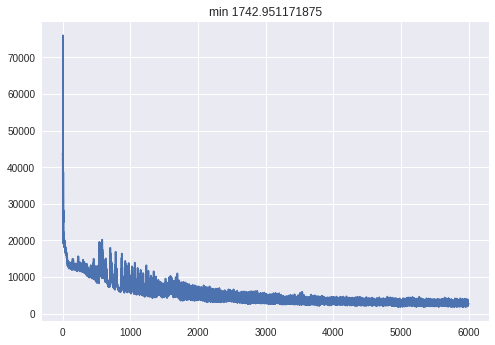

In [7]:
plt.plot(range(len(losses)), losses)
plt.title('min {}'.format(min(losses)))
plt.show()

# Use model

In [0]:
texture_type = 'fishes'

In [0]:

model = CNN3D()
model.load_state_dict(torch.load('../{}.pt'.format(texture_type)))
model = model.cuda()

## Generation

In [0]:
fold = './data/dynamic_textures/{}/'.format(texture_type)

target_seq_len = 6
seq_len = 50
path_target = fold

names = sorted(os.listdir(fold))[:-6]

imgs = [imgs_tensor for imgs_tensor, y in get_seq(path_target, target_seq_len)][-1]
imgs = imgs.cuda()

generated_imgs = []

for i in range(seq_len):

  new_img = model(imgs)

  generated_imgs += [deprocess(new_img)]
  imgs = torch.cat([imgs[:,:,list(range(target_seq_len - 1)),:,:,], new_img.view(1,3,1,256,256)], 2).cuda()


## Saving

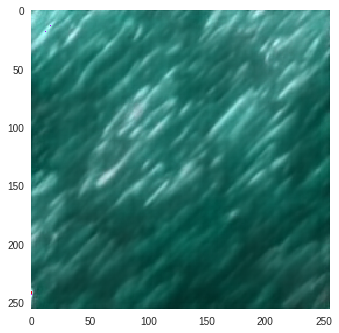

In [9]:
fold_save = './{}0/'.format(texture_type)

while os.path.isdir(fold_save):
  
  number = int(re.findall('\d+',fold_save)[-1]) + 1
  
  fold_save = './{}/'.format(texture_type + str(number)) 
  
os.mkdir(fold_save)

for i,img in enumerate(generated_imgs):
  
  plt.imshow(img)
  plt.grid(False)
  plt.imsave(fold_save + '{}.jpg'.format(i), img)